This project is at the intersection of `Machine Learning techniques` and `Data Analytics`, targeting on predicting the movements of `European Market Index`. Given the complex and often unpredictable nature of financial markets, traditional models have struggled to capture the full spectrum of market dynamics. This project proposes an approach by leveraging `Long Short-Term Memory (LSTM) networks`, a type of recurrent neural network that has shown exceptional promise in understanding and predicting sequences of data.

LSTMs are particularly suited for this task due to their ability to remember information over extended periods, making them ideal for the analysis of time series data, which is characteristic of stock market prices. By focusing on European Market Index, this research aims to uncover patterns and signals embedded in historical data, offering insights and predictive capabilities that can inform investment strategies and financial decision-making. This notebook serves as both a documentation of the project's methodology and a comprehensive guide for replicating the predictive analysis, illustrating the integration of cutting-edge data analytics techniques within the financial domain.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Stock Price Prediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/02 15:33:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/02 15:33:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Libraries

In [58]:
# Essential Libraries for Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Data Fetching and File Handling
import requests
import os
import gzip
import shutil
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

# Data Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from pandas import DataFrame, concat

# Machine Learning Preprocessing and Metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Deep Learning with Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from pmdarima import auto_arima

# Hyperparameter Optimization with Optuna
import optuna
from optuna.integration import KerasPruningCallback
import optuna.visualization as ov

# Time Series Analysis with Statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# PySpark for Large-Scale Data Processing
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, trim, when, isnan, count, mean, last, first, year
from pyspark.sql.window import Window
from functools import reduce
from operator import or_

# IPython Utilities for Interactive Notebooks
from IPython.display import FileLink
import cProfile  # Import cProfile for profiling
import pstats   # Import pstats for viewing the profiling results

# Serialization and Model Persistence
import joblib

# Warnings and Configuration
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Diable the warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import itertools
import warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# INDEX,Rates and Technical Indicators

## INDEX Indicator

## Technical Indicators

## Technical Indicator Analysis Commentary

In the analysis of the `EURO STOXX 50` Index, It has been identified that the Financial Modeling Prep (FMP) API was not feasible for extracting technical indicators such as SMA, EMA, and MACD (5+ Year Historical Data). This led to the implementation of an alternative approach using the pandas library in Python.

The methodology adhered to established financial analysis standards and utilized conventional computational techniques for the calculation of these indicators. The `Simple Moving Average (SMA)` and the `Exponential Moving Average (EMA)` were computed over a 50-day period. Additionally, the `Moving Average Convergence Divergence (MACD)` was calculated. Initially, the MACD's three components - the MACD line, the Signal line, and the MACD Histogram - were considered. However, the analysis was later refined to include only the MACD line to maintain focus and relevance.

Utilizing pandas for this purpose offered enhanced flexibility and control in data manipulation and calculations. This approach ensured that the analysis was not constrained by the limitations of external data sources or APIs. The resulting dataset, which begins from January 2, 2006, provides a detailed view of the index's performance with accurately computed SMA, EMA, and MACD values, facilitating a thorough technical analysis.

In [4]:
# Path to the CSV file on the desktop
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')  # Path to the desktop
file_path = os.path.join(desktop_path, 'STOXX50E.csv')  # File Name

# Load the dataset from the CSV file
index_df = pd.read_csv(file_path)

# Filter to only use 'date' and 'close' columns
index_df = index_df[['date', 'close']]

# Rename columns to 'Date' and 'Close'
index_df.rename(columns={'date': 'Date', 'close': 'Close'}, inplace=True)

# Convert 'Date' to datetime
index_df['Date'] = pd.to_datetime(index_df['Date'])

# Calculate the 50-day Simple Moving Average (SMA)
index_df['SMA'] = index_df['Close'].rolling(window=50, min_periods=1).mean()

# Calculate the 50-day Exponential Moving Average (EMA)
index_df['EMA'] = index_df['Close'].ewm(span=50, adjust=False).mean()

# Calculate only the MACD Line (12-day EMA - 26-day EMA)
index_df['MACD'] = index_df['Close'].ewm(span=12, adjust=False).mean() - index_df['Close'].ewm(span=26, adjust=False).mean()

# Filter the DataFrame for dates after 2006-01-02
index_data = index_df[index_df['Date'] >= pd.to_datetime('2006-01-02')]

# Convert 'Date' from datetime to date (to remove time component)
index_data['Date'] = index_data['Date'].dt.date

# Now, use describe() on the filtered DataFrame for the numerical columns
descriptive_stats = index_data[['Close', 'SMA', 'EMA', 'MACD']].describe()

# Print the descriptive statistics
print(descriptive_stats)

             Close          SMA          EMA         MACD
count  4580.000000  4580.000000  4580.000000  4580.000000
mean   3331.470597  3336.877300  3337.253795    -1.682844
std     608.188973   605.063876   601.451103    43.794864
min    1809.979981  2091.644585  2096.246724  -140.620963
25%    2880.682495  2880.461552  2874.442989   -28.815001
50%    3338.089966  3333.819001  3329.223542    -6.095822
75%    3740.507524  3726.657101  3703.855823    19.642689
max    4763.850100  4763.850100  4763.850100   275.182951


In [5]:
index_data.describe()

,Close,SMA,EMA,MACD
count,4580.000000,4580.000000,4580.000000,4580.000000
mean,3331.470597,3336.877300,3337.253795,-1.682844
std,608.188973,605.063876,601.451103,43.794864
min,1809.979981,2091.644585,2096.246724,-140.620963
25%,2880.682495,2880.461552,2874.442989,-28.815001
50%,3338.089966,3333.819001,3329.223542,-6.095822
75%,3740.507524,3726.657101,3703.855823,19.642689
max,4763.850100,4763.850100,4763.850100,275.182951


In [6]:
index_data.head()

,Date,Close,SMA,EMA,MACD
0,2024-02-16,4763.85010,4763.850100,4763.850100,0.000000
1,2024-02-15,4743.16992,4753.510010,4763.039113,-1.649701
2,2024-02-14,4709.22021,4738.746743,4760.928567,-5.631641
3,2024-02-13,4689.27979,4726.380005,4758.118811,-10.277905
4,2024-02-12,4746.35010,4730.374024,4757.657293,-9.248395


## Interest Rate API (Eurostat)

In [7]:
# Dataset code
dataset_code = "ei_mfir_m"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [8]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'ei_mfir_m.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 's_adj', 'p_adj', 'indic', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['indic'] == 'MF-3MI-RT')
]

# Drop unnecessary columns
structured_data.drop(['freq', 's_adj', 'p_adj'], axis=1, inplace=True)

# Filter for date range (from Jan, 2005, onwards)
date_columns = structured_data.columns[3:]
dates_from_2006 = date_columns[date_columns >= '2005-01 ']
structured_data = structured_data[['indic','geo'] + list(dates_from_2006)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [9]:
# Ensure that the date columns include '2005-01'
date_columns = structured_data.columns[4:]  # Starting from the 5th column
data_for_melting = structured_data[['geo'] + list(date_columns)]

# Melting the DataFrame
melted_data = pd.melt(data_for_melting, id_vars=['geo'], var_name='Period', value_name='Interest')

# Ensure 'Period' is of datetime type
melted_data['Period'] = pd.to_datetime(melted_data['Period'])

# Filter for 'geo' == 'EA'
Interest_data_ea = melted_data[melted_data['geo'] == 'EA']

# Apply forward filling
Interest_data_ea = Interest_data_ea.sort_values('Period')
Interest_data_ea['Interest'] = Interest_data_ea['Interest'].ffill()

# Reset index for a clean DataFrame
Interest_data_ea.reset_index(drop=True, inplace=True)

# Display the transformed DataFrame
print(Interest_data_ea.head(10))

  geo     Period  Interest
0  EA 2005-03-01  2.13720 
1  EA 2005-04-01  2.13720 
2  EA 2005-05-01  2.12560 
3  EA 2005-06-01  2.11100 
4  EA 2005-07-01  2.11940 
5  EA 2005-08-01  2.13250 
6  EA 2005-09-01  2.13910 
7  EA 2005-10-01  2.19660 
8  EA 2005-11-01  2.36090 
9  EA 2005-12-01  2.47290 


##### Forward Filling

In [10]:
# Convert 'Period' to datetime
Interest_data_ea['Period'] = pd.to_datetime(Interest_data_ea['Period'])

# Set 'Period' as the index
Interest_data_ea.set_index('Period', inplace=True)

# Create a daily date range that covers the entire period in your data
start_date = Interest_data_ea.index.min()
end_date = Interest_data_ea.index.max()
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex the DataFrame to this date range, forward filling the missing values
daily_interest_data = Interest_data_ea.reindex(all_days).ffill()

# Reset the index so 'Period' becomes a column again
daily_interest_data.reset_index(inplace=True)
daily_interest_data.rename(columns={'index': 'Period'}, inplace=True)

# Filter for dates starting from January 2, 2006
daily_interest_data = daily_interest_data[daily_interest_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
daily_interest_data = daily_interest_data[~daily_interest_data['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(daily_interest_data.head(10))

        Period geo  Interest
307 2006-01-02  EA  2.51170 
308 2006-01-03  EA  2.51170 
309 2006-01-04  EA  2.51170 
310 2006-01-05  EA  2.51170 
311 2006-01-06  EA  2.51170 
314 2006-01-09  EA  2.51170 
315 2006-01-10  EA  2.51170 
316 2006-01-11  EA  2.51170 
317 2006-01-12  EA  2.51170 
318 2006-01-13  EA  2.51170 


##### KNN Filling

In [11]:
# Check if 'Period' is in the columns; if not, the index might already be the 'Period'
if 'Period' in Interest_data_ea.columns:
    Interest_data_ea['Period'] = pd.to_datetime(Interest_data_ea['Period'])
    Interest_data_ea.set_index('Period', inplace=True)
elif not isinstance(Interest_data_ea.index, pd.DatetimeIndex):
    # If the index is not a datetime, convert it
    Interest_data_ea.index = pd.to_datetime(Interest_data_ea.index)

# Create a daily date range
start_date = Interest_data_ea.index.min()
end_date = Interest_data_ea.index.max()
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex to create a DataFrame with all days, introducing NaNs for days without data
interest_data = Interest_data_ea.reindex(all_days)

# Convert the index to a numerical value for KNN
interest_data['Day_Ordinal'] = interest_data.index.map(datetime.toordinal)

# Extract the 'Interest' column for imputation
knn_data = interest_data[['Day_Ordinal', 'Interest']].values

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Put the imputed 'Interest' data back into the DataFrame
interest_data['Interest'] = knn_data_imputed[:, 1]

# Drop the 'Day_Ordinal' column as it's no longer needed
interest_data.drop('Day_Ordinal', axis=1, inplace=True)

# Reset index to make 'Period' a column again
interest_data.reset_index(inplace=True)
interest_data.rename(columns={'index': 'Period'}, inplace=True)

# If the 'geo' column is required, fill it with a constant value (e.g., 'EA')
interest_data['geo'] = 'EA'

# Filter for dates starting from January 2, 2006
interest_data = interest_data[interest_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
interest_data = interest_data[~interest_data['Period'].dt.dayofweek.isin([5, 6])]


# Display the first 10 rows of the daily data
print(interest_data.head(10))

        Period geo  Interest
307 2006-01-02  EA    2.5337
308 2006-01-03  EA    2.5337
309 2006-01-04  EA    2.5337
310 2006-01-05  EA    2.5337
311 2006-01-06  EA    2.5337
314 2006-01-09  EA    2.5337
315 2006-01-10  EA    2.5337
316 2006-01-11  EA    2.5337
317 2006-01-12  EA    2.5337
318 2006-01-13  EA    2.5337


In [12]:
# Check for null values
null_counts = interest_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = interest_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (interest_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (interest_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)

Null Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

NaN Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

Zero Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

N/A Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64


## Bonds Yields API (Eurostat)

In [13]:
# Dataset code
dataset_code = "irt_euryld_d"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [14]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'irt_euryld_d.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 'yld_curv', 'maturity', 'bonds', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['yld_curv'] == 'SPOT_RT') & 
    (structured_data['bonds'] == 'CGB_EA')
]

# Drop unnecessary columns
structured_data.drop(['freq', 'geo'], axis=1, inplace=True)

# Filter for date range (from January 2, 2006, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2006-01-02 ']
structured_data = structured_data[['yld_curv', 'maturity', 'bonds'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [15]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[3:]  # Assuming date columns start from the 4th column
data_for_melting = structured_data[['maturity'] + list(date_columns)]

# Melt the DataFrame to change its structure
bonds_data = pd.melt(data_for_melting, id_vars=['maturity'], var_name='Period', value_name='Rate')

# Specify the desired maturities (M3 to M11 and Y1 to Y30)
desired_maturities = [f'M{i}' for i in range(0, 13)] + [f'Y{i}' for i in range(1, 31)]

# Filter the DataFrame to include only the specified maturities
bonds_data = bonds_data[bonds_data['maturity'].isin(desired_maturities)]

# Rearrange the columns
bonds_data = bonds_data[['Period', 'maturity', 'Rate']]

# Display the transformed DataFrame
pd.set_option('display.max_rows', None)  # This option displays all the rows
print(bonds_data.head())


        Period maturity     Rate
0  2006-01-02       M10  2.63864
1  2006-01-02       M11   2.6671
2  2006-01-02        M3  2.34702
3  2006-01-02        M4  2.40081
4  2006-01-02        M5  2.44996


In [16]:
# Check for null values
null_counts = bonds_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = bonds_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (bonds_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (bonds_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)

Null Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

NaN Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

Zero Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

N/A Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64


## Inflation Rate API (Eurostat)

In [17]:
# Dataset code
dataset_code = "prc_hicp_manr"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [18]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'prc_hicp_manr.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 'unit', 'coicop', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['unit'] == 'RCH_A') & 
    (structured_data['coicop'] == 'CP00')
]

# Drop unnecessary columns
structured_data.drop(['freq'], axis=1, inplace=True)

# Filter for date range (from January 1, 2005, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2005-01']
structured_data = structured_data[['unit', 'coicop', 'geo'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [19]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[3:]  # Include all date columns starting from the 4th column
data_for_melting = structured_data[['geo'] + list(date_columns)]

# Melting the DataFrame
melted_data = pd.melt(data_for_melting, id_vars=['geo'], var_name='Period', value_name='Inflation')

# Filter for 'geo' == 'EA' and convert 'Period' to datetime format
inflation_data_ea = melted_data[melted_data['geo'] == 'EA']
inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])

# Ensure the DataFrame is sorted by period and forward fill missing 'Inflation' values
inflation_data_ea = inflation_data_ea.sort_values(by='Period')
inflation_data_ea['Inflation'] = inflation_data_ea.groupby('geo')['Inflation'].ffill()

# Reset the index and display the DataFrame
inflation_data_ea = inflation_data_ea.reset_index(drop=True)
print(inflation_data_ea.head(10))

  geo     Period Inflation
0  EA 2005-01-01      1.9 
1  EA 2005-02-01      2.1 
2  EA 2005-03-01      2.2 
3  EA 2005-04-01      2.1 
4  EA 2005-05-01      2.0 
5  EA 2005-06-01      2.0 
6  EA 2005-07-01      2.1 
7  EA 2005-08-01      2.2 
8  EA 2005-09-01      2.6 
9  EA 2005-10-01      2.5 


##### Forward Filling

In [20]:
# Convert 'Period' to datetime
inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])

# Set 'Period' as the DataFrame index
inflation_data_ea.set_index('Period', inplace=True)

# Resample to daily data using forward fill
daily_data_ffill = inflation_data_ea.resample('D').ffill()

# Reset index to move 'Period' back to a column
daily_data_ffill.reset_index(inplace=True)

# Filter for dates starting from January 2, 2006
daily_data_ffill = daily_data_ffill[daily_data_ffill['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
daily_data_ffill = daily_data_ffill[~daily_data_ffill['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(daily_data_ffill.head(10))

        Period geo Inflation
366 2006-01-02  EA      2.4 
367 2006-01-03  EA      2.4 
368 2006-01-04  EA      2.4 
369 2006-01-05  EA      2.4 
370 2006-01-06  EA      2.4 
373 2006-01-09  EA      2.4 
374 2006-01-10  EA      2.4 
375 2006-01-11  EA      2.4 
376 2006-01-12  EA      2.4 
377 2006-01-13  EA      2.4 


##### KNN Filling

In [21]:
# Check if 'Period' is in the columns; if not, the index should already be the 'Period'
if 'Period' in inflation_data_ea.columns:
    inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])
    inflation_data_ea.set_index('Period', inplace=True)
elif not isinstance(inflation_data_ea.index, pd.DatetimeIndex):
    # If the index is not a datetime, convert it
    inflation_data_ea.index = pd.to_datetime(inflation_data_ea.index)

# Convert non-numeric values to NaN in the 'Inflation' column
inflation_data_ea['Inflation'] = pd.to_numeric(inflation_data_ea['Inflation'], errors='coerce')

# Create a daily date range that covers the entire period of your data
date_range = pd.date_range(start=inflation_data_ea.index.min(), end=inflation_data_ea.index.max(), freq='D')

# Create a new DataFrame for KNN imputation
inflation_data = pd.DataFrame(date_range, columns=['Period'])

# Merge with your existing data - this will introduce NaNs for days without data
inflation_data = inflation_data.merge(inflation_data_ea, how='left', left_on='Period', right_index=True)

# Convert 'Period' to a numerical value (e.g., days since start)
min_date = inflation_data['Period'].min()
inflation_data['Day_Ordinal'] = (inflation_data['Period'] - min_date).dt.days

# Prepare data for KNN imputation
knn_data = inflation_data[['Day_Ordinal', 'Inflation']]

# Initialize KNN Imputer - 5 neighbors / Week
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Add imputed data back to DataFrame
inflation_data['Inflation'] = knn_data_imputed[:, 1]

# Fill 'geo' column with 'EA'
inflation_data['geo'] = 'EA'

# Convert 'Day_Ordinal' back to datetime
inflation_data['Period'] = inflation_data['Day_Ordinal'].apply(lambda x: min_date + timedelta(days=x))

# Drop the 'Day_Ordinal' column
inflation_data.drop(columns='Day_Ordinal', inplace=True)

# Filter for dates starting from January 2, 2006
inflation_data = inflation_data[inflation_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
inflation_data = inflation_data[~inflation_data['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(inflation_data.head(10))

        Period geo  Inflation
366 2006-01-02  EA       2.32
367 2006-01-03  EA       2.32
368 2006-01-04  EA       2.32
369 2006-01-05  EA       2.32
370 2006-01-06  EA       2.32
373 2006-01-09  EA       2.32
374 2006-01-10  EA       2.32
375 2006-01-11  EA       2.32
376 2006-01-12  EA       2.32
377 2006-01-13  EA       2.32


In [22]:
# Check for null values
null_counts = inflation_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = inflation_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (inflation_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (inflation_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)


Null Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64

NaN Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64

Zero Values in Each Column:
 Period       0
geo          0
Inflation    3
dtype: int64

N/A Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64


# SparkSQL: Tables Connection

In [23]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Stock Market Trends Analysis") \
    .getOrCreate()

# Function to format date columns in Pandas DataFrame
def format_date_columns(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column]).dt.date
    return df

# Format date columns
index_data = format_date_columns(index_data, 'Date')
interest_data = format_date_columns(interest_data, 'Period')
bonds_data = format_date_columns(bonds_data, 'Period')
inflation_data = format_date_columns(inflation_data, 'Period')

# Convert Pandas DataFrame to Spark DataFrame
index_df_spark = spark.createDataFrame(index_data)
interest_df_spark = spark.createDataFrame(interest_data)
bonds_df_spark = spark.createDataFrame(bonds_data)
inflation_df_spark = spark.createDataFrame(inflation_data)

# Trim and convert date columns to DateType
index_df_spark = index_df_spark.withColumn("Date", to_date(trim(col("Date")), "yyyy-MM-dd"))
interest_df_spark = interest_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))
bonds_df_spark = bonds_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))
inflation_df_spark = inflation_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))

# Create Temporary Views
index_df_spark.createOrReplaceTempView("indexView")
interest_df_spark.createOrReplaceTempView("interestView")
bonds_df_spark.createOrReplaceTempView("bondsView")
inflation_df_spark.createOrReplaceTempView("inflationView")

# Pivot and process bonds data to have maturity rates as separate columns
bonds_df_pivoted = bonds_df_spark.groupBy("Period").pivot("maturity").agg(first("Rate"))
bonds_df_pivoted.createOrReplaceTempView("bondsPivotedView")

# SQL Query for Joining
join_query = """
SELECT i.Date, i.Close, i.MACD, i.SMA, i.EMA,
       int.Interest as InterestRate, 
       inf.Inflation as InflationRate,
       b.M3, b.M6, b.M9, b.Y1, b.Y3, b.Y5, b.Y10, b.Y20, b.Y30
FROM indexView i
LEFT JOIN interestView int ON i.Date = int.Period
LEFT JOIN bondsPivotedView b ON i.Date = b.Period
LEFT JOIN inflationView inf ON i.Date = inf.Period
"""

# Execute the query and show the Result
dataset = spark.sql(join_query)
dataset.show(10)

24/09/02 15:34:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/09/02 15:34:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+----------+-------------------+------------------+------------------+------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|     Close|               MACD|               SMA|               EMA|InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+----------+-------------------+------------------+------------------+------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2024-02-05|4655.27002| -21.39123992203531|       4710.351027|4745.2460523204845|     3.91808|              2.62|3.88726| 3.6421|3.43694|3.26609|2.66683|2.66288|3.01592| 3.3946|3.46675|
|2024-02-16| 4763.8501|                0.0|         4763.8501|         4763.8501|      3.8942|2.5599999999999996|3.89213|3.69046|3.51988|3.37617|2.84118|2.80438|3.07186|3.39073|3.44119|
|2024-02-09|4715.87012|-10.767856403392216| 4727.956706666667|   4756.

In [24]:
# DataFrame: joined_df
numeric_column_types = ['int', 'double', 'float', 'long']

# Counting zeros and nulls for each column
for column in dataset.columns:
    # Check if the column is numeric
    if str(dataset.schema[column].dataType) in numeric_column_types:
        zero_count = dataset.filter(col(column) == 0).count()
        null_or_nan_count = joined_df.filter(col(column).isNull() | isnan(col(column))).count()
    else:
        zero_count = 'N/A' # Not applicable for non-numeric columns
        null_or_nan_count = dataset.filter(col(column).isNull()).count() # Check only for nulls in non-numeric columns

    print(f"Column '{column}': Zeros = {zero_count}, Nulls or NaNs = {null_or_nan_count}")

Column 'Date': Zeros = N/A, Nulls or NaNs = 0
Column 'Close': Zeros = N/A, Nulls or NaNs = 0
Column 'MACD': Zeros = N/A, Nulls or NaNs = 0
Column 'SMA': Zeros = N/A, Nulls or NaNs = 0
Column 'EMA': Zeros = N/A, Nulls or NaNs = 0
Column 'InterestRate': Zeros = N/A, Nulls or NaNs = 0
Column 'InflationRate': Zeros = N/A, Nulls or NaNs = 0


Column 'M3': Zeros = N/A, Nulls or NaNs = 15


Column 'M6': Zeros = N/A, Nulls or NaNs = 15


Column 'M9': Zeros = N/A, Nulls or NaNs = 15


Column 'Y1': Zeros = N/A, Nulls or NaNs = 15


Column 'Y3': Zeros = N/A, Nulls or NaNs = 15
Column 'Y5': Zeros = N/A, Nulls or NaNs = 15
Column 'Y10': Zeros = N/A, Nulls or NaNs = 15
Column 'Y20': Zeros = N/A, Nulls or NaNs = 15
Column 'Y30': Zeros = N/A, Nulls or NaNs = 15


In [25]:
# DataFrame: dataset
numeric_column_types = ['int', 'double', 'float', 'long']

# Initialize an empty dictionary to store columns with non-zero null, NaN, or N/A counts
columns_with_missing_values = {}

# Counting zeros and nulls for each column
for column in dataset.columns:
    # Check if the column is numeric
    if str(dataset.schema[column].dataType) in numeric_column_types:
        zero_count = dataset.filter(col(column) == 0).count()
        null_or_nan_count = dataset.filter(col(column).isNull() | isnan(col(column))).count()
    else:
        zero_count = 'N/A'  # Not applicable for non-numeric columns
        null_or_nan_count = dataset.filter(col(column).isNull()).count()  # Check only for nulls in non-numeric columns

    # Add to dictionary if there are non-zero nulls, NaNs, or zeros for numeric columns
    if zero_count != 'N/A':
        if null_or_nan_count > 0 or zero_count > 0:
            columns_with_missing_values[column] = {'Zeros': zero_count, 'Nulls_or_NaNs': null_or_nan_count}
    else:
        if null_or_nan_count > 0:
            columns_with_missing_values[column] = {'Zeros': zero_count, 'Nulls_or_NaNs': null_or_nan_count}

# Display columns with missing values
for column, counts in columns_with_missing_values.items():
    print(f"Column '{column}': Zeros = {counts['Zeros']}, Nulls or NaNs = {counts['Nulls_or_NaNs']}")

Column 'M3': Zeros = N/A, Nulls or NaNs = 15
Column 'M6': Zeros = N/A, Nulls or NaNs = 15
Column 'M9': Zeros = N/A, Nulls or NaNs = 15
Column 'Y1': Zeros = N/A, Nulls or NaNs = 15
Column 'Y3': Zeros = N/A, Nulls or NaNs = 15
Column 'Y5': Zeros = N/A, Nulls or NaNs = 15
Column 'Y10': Zeros = N/A, Nulls or NaNs = 15
Column 'Y20': Zeros = N/A, Nulls or NaNs = 15
Column 'Y30': Zeros = N/A, Nulls or NaNs = 15


In [26]:
from pyspark.sql.functions import col, isnan

# Function to create a column condition for checking if a column is null or NaN
def is_missing(column_name):
    return col(column_name).isNull() | isnan(col(column_name))

# Create a combined condition for all bond rate columns
bond_rate_conditions = is_missing('M3') | is_missing('M6') | is_missing('M9') | \
                       is_missing('Y1') | is_missing('Y3') | is_missing('Y5') | \
                       is_missing('Y10') | is_missing('Y20') | is_missing('Y30')

# Count the total number of rows
total_rows = dataset.count()

# Count rows where any one of the specific columns is missing
missing_columns_count = dataset.filter(
    is_missing("InterestRate") |
    bond_rate_conditions |
    is_missing("InflationRate") &
    col("Close").isNotNull()
).count()

# Calculate the percentage of such instances
percentage_missing_columns = (missing_columns_count / total_rows) * 100

print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing rates: {missing_columns_count}")
print(f"Percentage of Rows with missing any rate: {percentage_missing_columns:.2f}%")

# Filter the DataFrame to get rows with missing values in specific columns
missing_values_table = dataset.filter(
    is_missing("InterestRate") |
    bond_rate_conditions |
    is_missing("InflationRate") &
    col("Close").isNotNull()
)

# Show the rows with missing values
missing_values_table.show()

Total Rows: 4580
Rows with 'Close' but missing rates: 15
Percentage of Rows with missing any rate: 0.33%
+----------+------------+-------------------+------------------+------------------+--------------------+------------------+----+----+----+----+----+----+----+----+----+
|      Date|       Close|               MACD|               SMA|               EMA|        InterestRate|     InflationRate|  M3|  M6|  M9|  Y1|  Y3|  Y5| Y10| Y20| Y30|
+----------+------------+-------------------+------------------+------------------+--------------------+------------------+----+----+----+----+----+----+----+----+----+
|2022-06-22|3464.6398926|-28.238746293933218|3601.7518102999998| 3549.685222696644|             0.16346|              8.92|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|2020-12-24| 3543.280029| -20.92007916041166|3630.2670117280004|3650.4786437896482| -0.5372800000000001|               0.5|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|2023-04-06|     4309.45| 3.2365688713516647|     

## Window Approuch

In [27]:
# 'Date' column can be used for partitioning
window_spec_forward = Window.partitionBy(year("Date")).orderBy("Date").rowsBetween(Window.unboundedPreceding, Window.currentRow)
window_spec_backward = Window.partitionBy(year("Date")).orderBy("Date").rowsBetween(Window.currentRow, Window.unboundedFollowing)

# List of all columns to be filled
columns_to_fill = ['InterestRate', 'InflationRate'] + ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Apply forward fill followed by backward fill for each column
for col_name in columns_to_fill:
    dataset_ff = dataset.withColumn(col_name, last(col_name, ignorenulls=True).over(window_spec_forward))
    dataset_ff = dataset_ff.withColumn(col_name, last(col_name, ignorenulls=True).over(window_spec_backward))

# Show the result
dataset_ff.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|4.19102|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|4.19102|
|2006-01-04|3652.459961|-11.4738414

In [28]:
# Create a combined condition for all bond rate columns
bond_rate_conditions = (
    col("M3").isNull() | isnan(col("M3")) |
    col("M6").isNull() | isnan(col("M6")) |
    col("M9").isNull() | isnan(col("M9")) |
    col("Y1").isNull() | isnan(col("Y1")) |
    col("Y3").isNull() | isnan(col("Y3")) |
    col("Y5").isNull() | isnan(col("Y5")) |
    col("Y10").isNull() | isnan(col("Y10")) |
    col("Y20").isNull() | isnan(col("Y20")) |
    col("Y30").isNull() | isnan(col("Y30"))
)

# Count rows where 'Close' is available but any one of 'InterestRate', bond rate columns, or 'InflationRate' is missing (Null or NaN)
missing_any_column_count = dataset_ff.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        bond_rate_conditions |
        col("InflationRate").isNull() | isnan(col("InflationRate"))
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': {missing_any_column_count}")
print(f"Percentage of Rows with missing any one rate: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': 15
Percentage of Rows with missing any one rate: 0.33%


Here's why the Window function is used:

    Row-wise Calculations: PySpark's Window function allows you to specify a range of rows (a window) relative to the current row and perform calculations across these rows.

    Emulating ffill: By ordering the rows in the window based on the 'date' column and then using the last function (which returns the last non-null value in the window), we effectively emulate the forward fill behavior. It picks the last non-null value encountered in the ordered window and applies it to the current row if the current value is null.

    Scalability and Performance: PySpark is designed for big data processing. While Pandas' ffill is straightforward and efficient for in-memory data on a single machine, PySpark's window functions are designed to work efficiently on distributed datasets across multiple nodes in a cluster.

    Lack of Direct ffill Equivalent: PySpark DataFrame API does not have a direct method like ffill in Pandas. Therefore, the combination of Window and last functions is a common approach to achieve similar functionality.

#### MEAN to fill the Missing Day Value

In [29]:
# Define the numeric columns for interest rate, inflation rate, and bond rates
numeric_cols = ["InterestRate", "InflationRate"] + ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Calculate the mean of non-null values for each column
mean_values = dataset_ff.select([mean(c).alias(c) for c in numeric_cols]).collect()[0].asDict()

# Fill null values with the mean for each column
for col in numeric_cols:
    dataset_ff = dataset_ff.na.fill({col: mean_values[col]})

# Show the result
dataset_ff.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|4.19102|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|4.19102|
|2006-01-04|3652.459961|-11.4738414

In [30]:
from pyspark.sql.functions import col, isnan
from functools import reduce
from pyspark.sql import functions as F

# Define the bond rate columns
bond_rate_cols = ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Create a combined condition to check for missing values in bond rate columns
bond_rate_missing_condition = [col(c).isNull() | isnan(col(c)) for c in bond_rate_cols]

# Combine all conditions using a logical OR
combined_bond_rate_condition = reduce(lambda x, y: x | y, bond_rate_missing_condition)

# Count the total number of rows
total_rows = dataset_ff.count()

# Count rows where 'Close' is available but any one of the rate columns is missing (Null or NaN)
missing_any_column_count = dataset_ff.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate")) |
        combined_bond_rate_condition
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing any rate information: {missing_any_column_count}")
print(f"Percentage of Rows with missing rate information: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Close' but missing any rate information: 0
Percentage of Rows with missing rate information: 0.00%


## KNN Approuch

In [31]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_pd = dataset.toPandas()

# Define the list of numeric columns including interest rate, inflation rate, and bond rate columns
numeric_cols = ["InterestRate", "InflationRate", "M3", "M6", "M9", "Y1", "Y3", "Y5", "Y10", "Y20", "Y30"]

# Replace non-numeric values to NaN
dataset_pd[numeric_cols] = dataset_pd[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
dataset_pd[numeric_cols] = knn_imputer.fit_transform(dataset_pd[numeric_cols])

# Convert back to Spark DataFrame
dataset_knn = spark.createDataFrame(dataset_pd)

In [32]:
# Sort the DataFrame in ascending order by the 'date' column
dataset_knn = dataset_knn.orderBy("Date")

# Show the result
dataset_knn.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|3.87534|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|3.86669|
|2006-01-04|3652.459961|-11.4738414

In [33]:
# Define all Bond Rate columns
bond_rate_columns = ["M3", "M6", "M9", "Y1", "Y3", "Y5", "Y10", "Y20", "Y30"]

# Create a condition to check for missing values in any bond rate column
bond_rate_missing_condition = reduce(or_, [col(name).isNull() | isnan(col(name)) for name in bond_rate_columns])

# Count the total number of rows
total_rows = dataset_knn.count()

# Count rows where 'Close' is available but any one of the rate columns is missing (Null or NaN)
missing_any_column_count = dataset_knn.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate")) |
        bond_rate_missing_condition
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing any rate information: {missing_any_column_count}")
print(f"Percentage of Rows with missing rate information: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Close' but missing any rate information: 0
Percentage of Rows with missing rate information: 0.00%


# ARIMA & LSTM

## 1- Load and Structure the Data

In [34]:
# Dataset_knn is a Spark DataFrame, convert it to a Pandas DataFrame
dataset_knn_pandas = dataset_knn.toPandas()

# Sort the DataFrame in ascending order by the 'Date' column
dataset_knn_pandas = dataset_knn_pandas.sort_values(by='Date')

# Ensure the 'Date' column is datetime
dataset_knn_pandas['Date'] = pd.to_datetime(dataset_knn_pandas['Date'])

# Ensure 'Close' is a float and drop NaN values
dataset_knn_pandas['Close'] = dataset_knn_pandas['Close'].astype(float)
dataset_knn_pandas.dropna(subset=['Close'], inplace=True)

In [35]:
# Convert the 'Date' column to date format
dataset_knn = dataset_knn.withColumn('Date', to_date(col('Date')))

# Define the start and end dates for the date range
start_date = '2007-01-02'
end_date = '2024-02-13'

# Filter the dataset to include only rows within the specified date range
dataset_knn = dataset_knn.filter((col('Date') >= start_date) & (col('Date') <= end_date))

# Drop rows with any NaN values
dataset_knn = dataset_knn.na.drop()

# Show the max and min dates in the capped dataset to verify
min_date = dataset_knn.agg({"Date": "min"}).collect()[0][0]
max_date = dataset_knn.agg({"Date": "max"}).collect()[0][0]
print(f"Data capped from: {min_date} to {max_date}")

# Display the first 10 rows to verify the dataset
dataset_knn.show(10)

Data capped from: 2007-01-03 to 2024-02-13
+----------+-----------+-------------------+------------------+------------------+------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2007-01-03|4188.240234| -8.511311695257973|     4164.90419922| 4181.063391854702|     3.74848|1.8400000000000003|3.47207|3.61962|3.70464| 3.7528|3.80392|3.82737|3.95271|4.10548|4.16607|
|2007-01-04|4177.759766| -12.39892159014562|     4159.26239258|  4180.77045952224|     3.74848|1.8400000000000003|3.48645|3.63042|3.71342|3.76039|3.81012|3.83536|3.96503|4.12047|4.18173|
|2007-01-05|4129.35009

In [36]:
print(dataset_knn_pandas.index)

RangeIndex(start=0, stop=4580, step=1)


In [37]:
print(dataset_knn_pandas.columns)

Index(['Date', 'Close', 'MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate',
       'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30'],
      dtype='object')


## 2- Stationarize the Data (For ARIMA)

### 2.1- Analyze if the Dataset is Stationary

In [38]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_knn_pandas = dataset_knn.toPandas()

# Ensure 'Close' is a float and drop NaN values
dataset_knn_pandas['Close'] = dataset_knn_pandas['Close'].astype(float)
dataset_knn_pandas.dropna(subset=['Close'], inplace=True)

# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1]  # Return the p-value

# Perform ADF test on the Close price
p_value = adf_test(dataset_knn_pandas['Close'])

if p_value > 0.05:
    print("The data is non-stationary.")
else:
    print("The data is stationary.")

ADF Statistic: -1.8153931481900316
p-value: 0.37284664524104116
Critical Values:
   1%: -3.431866031861332
   5%: -2.862209898783688
   10%: -2.5671265919448807
The data is non-stationary.


### 2.2 Turn the Data Stationary

In [39]:
# Differencing to make data stationary
differencing_order = 0
while p_value > 0.05:
    differencing_order += 1
    dataset_knn_pandas['Close_diff'] = dataset_knn_pandas['Close'].diff(differencing_order).dropna()
    p_value = adf_test(dataset_knn_pandas['Close_diff'])

print(f'Data is stationary after {differencing_order} differencing(s)')

ADF Statistic: -28.101396713283357
p-value: 0.0
Critical Values:
   1%: -3.4318667351229823
   5%: -2.8622102094592465
   10%: -2.5671267573332957
Data is stationary after 1 differencing(s)


### 2.2 Recheck ADF after Differencing

In [40]:
# Recheck ADF after differencing
p_value_diff = adf_test(dataset_knn_pandas['Close_diff'])
if p_value_diff > 0.05:
    print("The differenced data is still non-stationary.")
else:
    print("The differenced data is now stationary.")

ADF Statistic: -28.101396713283357
p-value: 0.0
Critical Values:
   1%: -3.4318667351229823
   5%: -2.8622102094592465
   10%: -2.5671267573332957
The differenced data is now stationary.


### 2.3 Plot Non-Stationary and Stationary Data

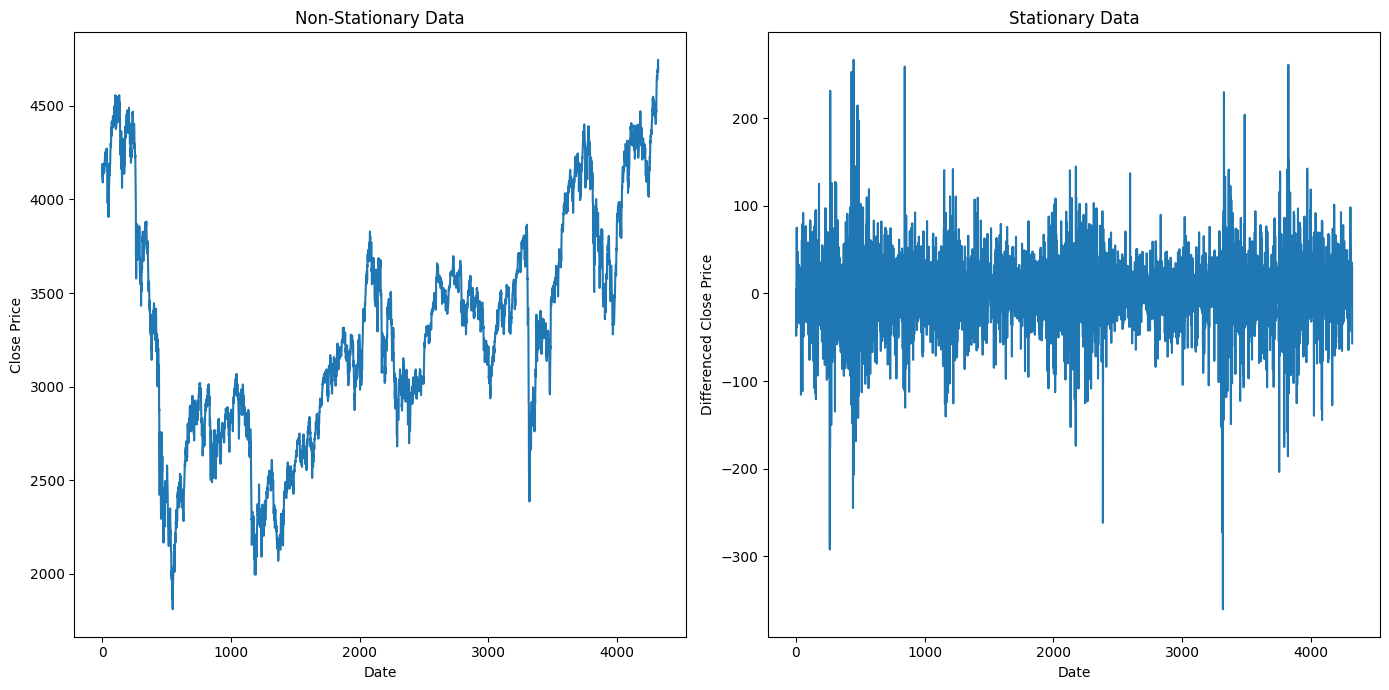

In [41]:
# Plot non-stationary data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(dataset_knn_pandas['Close'])
plt.title('Non-Stationary Data')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Plot stationary data
plt.subplot(1, 2, 2)
plt.plot(dataset_knn_pandas['Close_diff'].dropna())
plt.title('Stationary Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')

plt.tight_layout()
plt.show()

### 2.4 Partial Autocorrelation (PACF) and Autocorrelation (ACF)

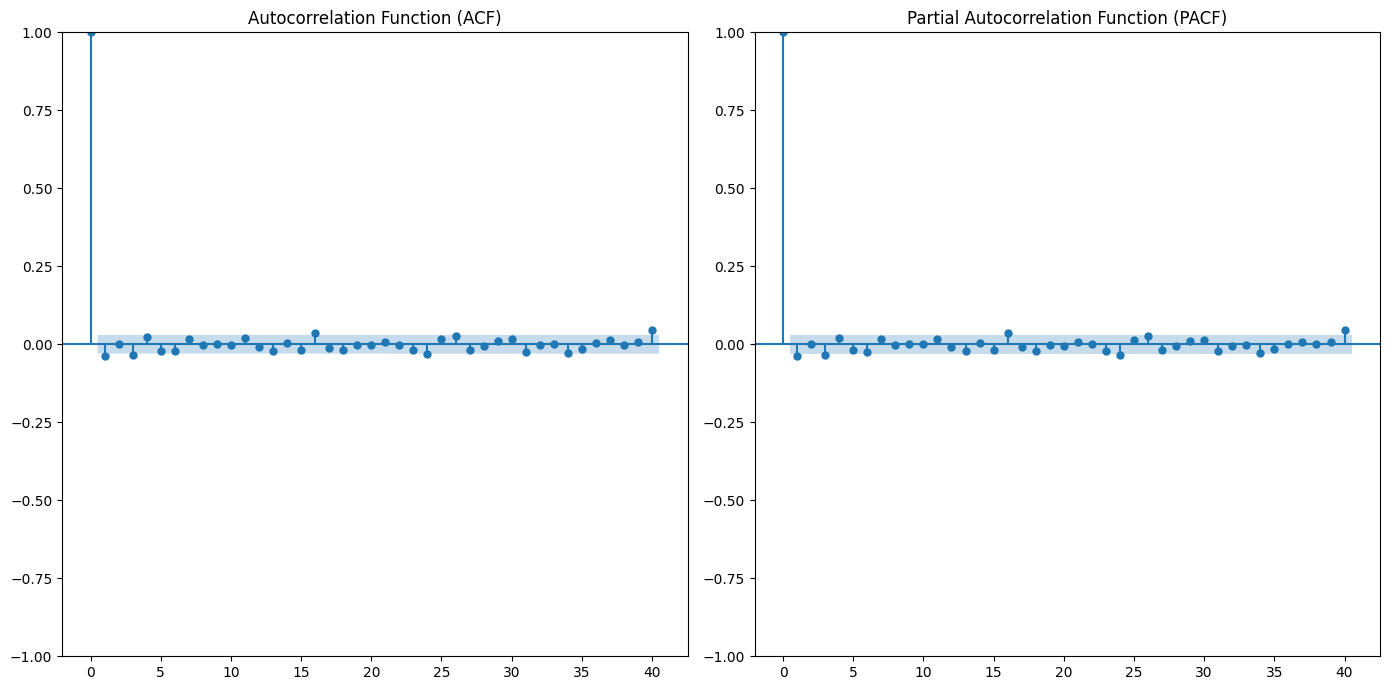

In [42]:
# Plot ACF and PACF
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plot_acf(dataset_knn_pandas['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(dataset_knn_pandas['Close_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [43]:
print(dataset_knn_pandas.columns)

Index(['Date', 'Close', 'MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate',
       'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30', 'Close_diff'],
      dtype='object')


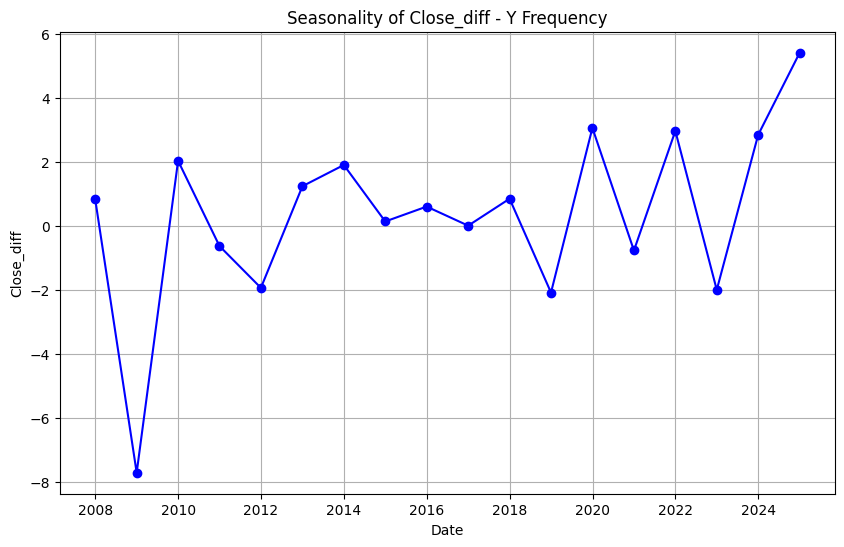

In [44]:
# Ensure 'Date' is set as index
if 'Date' in dataset_knn_pandas.columns:
    dataset_knn_pandas['Date'] = pd.to_datetime(dataset_knn_pandas['Date'])
    dataset_knn_pandas.set_index('Date', inplace=True)
else:
    dataset_knn_pandas.index = pd.to_datetime(dataset_knn_pandas.index)

# Resample the data to the yearly frequency to observe seasonality
def plot_seasonality(data, value_col, freq='Y'):
    data_resampled = data[value_col].resample(freq).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(data_resampled, marker='o', linestyle='-', color='b')
    plt.title(f'Seasonality of {value_col} - {freq} Frequency')
    plt.xlabel('Date')
    plt.ylabel(value_col)
    plt.grid(True)
    plt.show()

# Example
plot_seasonality(dataset_knn_pandas, 'Close_diff', freq='Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


          t-1       t+1
t-1  1.000000  0.017794
t+1  0.017794  1.000000


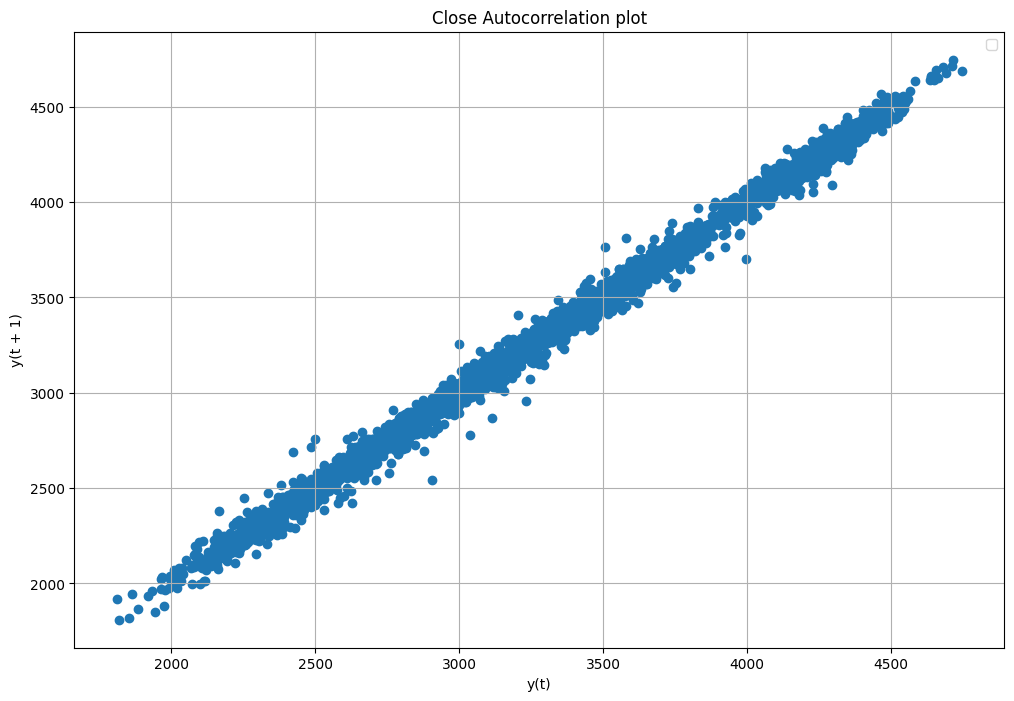

In [45]:
plt.figure(figsize=(12,8))
lag_plot(dataset_knn_pandas['Close'], lag=1)
plt.title('Close Autocorrelation plot')
plt.grid(True)
plt.legend();


values = DataFrame(dataset_knn_pandas['Close_diff'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

In [46]:
# Save the dataset to a CSV file
dataset_knn_pandas.to_csv('dataset_knn_pandas.csv')

# Save the dataset to a pickle file
dataset_knn_pandas.to_pickle('dataset_knn_pandas.pkl')

In [47]:
# Create a download link for the CSV file
FileLink('dataset_knn_pandas.csv')

# Create a download link for the Pickle file
FileLink('dataset_knn_pandas.pkl')

/home/fabiopoli/Desktop/dataset_knn_pandas.pkl

## 3- Build and Evaluate ARIMA Models

### 3.1 Arima

In [48]:
series = dataset_knn_pandas['Close']

# Define the p, d, and q parameters to take values between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Iterate over all combinations and fit ARIMA models
model_results = []
for param in pdq:
    try:
        model = ARIMA(series, order=param)
        results = model.fit()
        model_results.append({
            'Order': param,
            'AIC': results.aic,
            'BIC': results.bic
        })
        print(f'ARIMA{param} - AIC:{results.aic} - BIC:{results.bic}')
    except:
        continue

# Convert the results to a DataFrame
results_df = pd.DataFrame(model_results)

# Sort by AIC and BIC
sorted_results_aic = results_df.sort_values(by='AIC')
sorted_results_bic = results_df.sort_values(by='BIC')

# Display the top models based on AIC and BIC
print("\nTop models based on AIC:")
print(sorted_results_aic.head())

print("\nTop models based on BIC:")
print(sorted_results_bic.head())

ARIMA(0, 0, 0) - AIC:67729.58898557628 - BIC:67742.33146984814
ARIMA(0, 0, 1) - AIC:62200.52240541192 - BIC:62219.636131819716
ARIMA(0, 0, 2) - AIC:57901.9150844854 - BIC:57927.40005302913
ARIMA(0, 1, 0) - AIC:44727.763057491786 - BIC:44734.13406817302
ARIMA(0, 1, 1) - AIC:44724.005502095584 - BIC:44736.74752345806
ARIMA(0, 1, 2) - AIC:44726.00575279141 - BIC:44745.118784835126
ARIMA(0, 2, 0) - AIC:47866.064452692015 - BIC:47872.435231864976
ARIMA(0, 2, 1) - AIC:44728.666072161475 - BIC:44741.4076305074
ARIMA(0, 2, 2) - AIC:44724.94920544568 - BIC:44744.06154296456
ARIMA(1, 0, 0) - AIC:44744.464108489934 - BIC:44763.57783489773
ARIMA(1, 0, 1) - AIC:44741.099239975425 - BIC:44766.584208519154
ARIMA(1, 0, 2) - AIC:44743.09096364109 - BIC:44774.94717432075
ARIMA(1, 1, 0) - AIC:44723.999496469994 - BIC:44736.74151783247
ARIMA(1, 1, 1) - AIC:44725.961567861435 - BIC:44745.07459990515
ARIMA(1, 1, 2) - AIC:44725.555766736856 - BIC:44751.03980946181
ARIMA(1, 2, 0) - AIC:46514.66795146297 - BIC

In [49]:
# Extract the 'Close' series
series = dataset_knn_pandas['Close']

# Define the train/test split
split_point = int(len(series) * 0.8)
train, test = series.iloc[:split_point], series.iloc[split_point:]

def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Evaluate ARIMA model for a specific order with a 5-day forecast horizon
def evaluate_arima_model(arima_order, forecast_horizon=5):
    history = train.tolist()
    predictions = []
    for t in range(0, len(test), forecast_horizon):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=forecast_horizon)
        predictions.extend(yhat)
        history.extend(test.iloc[t:t+forecast_horizon].tolist())
    predictions = predictions[:len(test)]
    rmse = sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test, predictions)
    mape = calculate_mape(test, predictions)
    return rmse, r2, mape

# Selected ARIMA orders for evaluation
selected_orders = [(1, 1, 0), (1, 1, 1)]

results = []
for order in selected_orders:
    rmse, r2, mape = evaluate_arima_model(order, forecast_horizon=5)
    results.append({'ARIMA_Order': order, 'RMSE': rmse, 'R2': r2, 'MAPE': mape})
    print(f'ARIMA{order} - RMSE: {rmse}, R2: {r2}, MAPE: {mape}')

# Display the results
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\nTop models based on RMSE, R2, and MAPE:")
print(results_df)

# Save the results to a CSV file for later reference
results_df.to_csv('arima_model_evaluation_results.csv', index=False)

ARIMA(1, 1, 0) - RMSE: 68.79984091273462, R2: 0.9611302482268014, MAPE: 1.2767632989845894
ARIMA(1, 1, 1) - RMSE: 68.98456326191565, R2: 0.9609212433572598, MAPE: 1.2808510181089152

Top models based on RMSE, R2, and MAPE:
  ARIMA_Order       RMSE        R2      MAPE
0   (1, 1, 0)  68.799841  0.961130  1.276763
1   (1, 1, 1)  68.984563  0.960921  1.280851


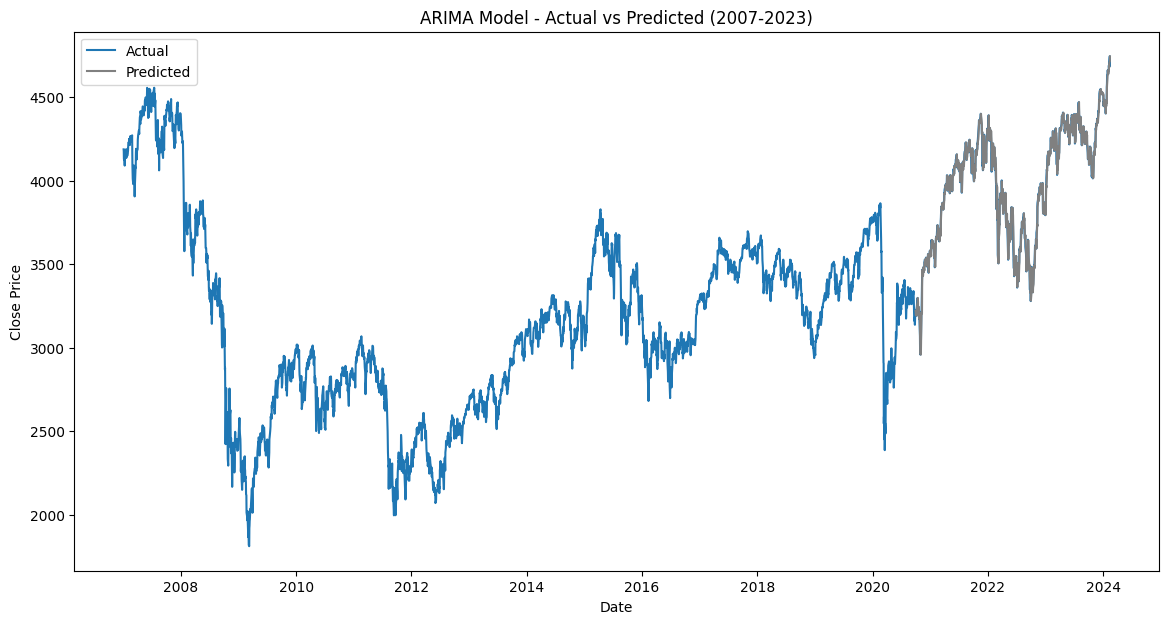

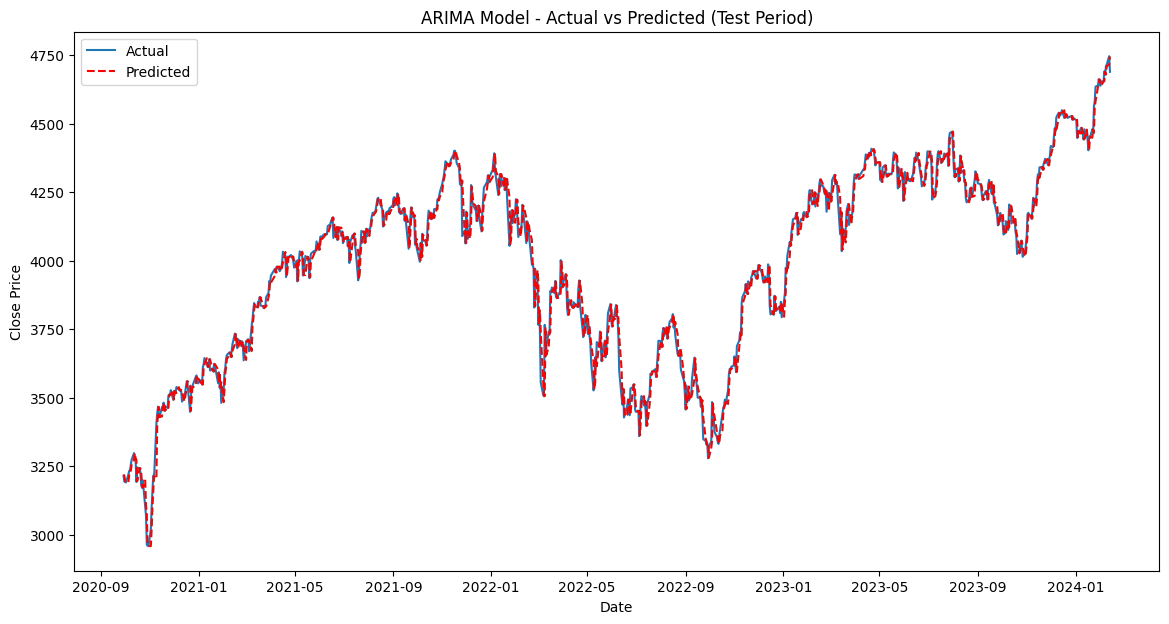

In [50]:
# Rebuild the history to include only the training data
history = list(train)
predictions = []

# Generate predictions for the test set only
for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

# Create a series for the predicted values with the same index as the test data
predicted_series = pd.Series(predictions, index=test.index)

# Plot the actual vs predicted values for the entire period (2007-2023)
plt.figure(figsize=(14, 7))
plt.plot(series, label='Actual')  # Plot full actual series
plt.plot(predicted_series, label='Predicted', color='gray')  # Plot predicted values only in the test period
plt.title('ARIMA Model - Actual vs Predicted (2007-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Zoom in on the test period to make the predictions more visible
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predicted_series, label='Predicted', color='red', linestyle='dashed')
plt.title('ARIMA Model - Actual vs Predicted (Test Period)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### 3.2 AutoArima

In [53]:
# Extract the 'Close' series
series = dataset_knn_pandas['Close']

# Define the train/test split
split_point = int(len(series) * 0.8)
train, test = series.iloc[:split_point], series.iloc[split_point:]

def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Use auto_arima to find the best p, d, q values automatically
auto_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Evaluate the best model found by auto_arima using a 5-day forecast horizon
def evaluate_autoarima_model(auto_model, forecast_horizon=5):
    history = train.tolist()
    predictions = []
    for t in range(0, len(test), forecast_horizon):
        model_fit = auto_model.fit(history)
        yhat = model_fit.predict(n_periods=forecast_horizon)
        predictions.extend(yhat)
        history.extend(test.iloc[t:t+forecast_horizon].tolist())
    predictions = predictions[:len(test)]
    rmse = sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test, predictions)
    mape = calculate_mape(test, predictions)
    return rmse, r2, mape

# Evaluate the model
rmse, r2, mape = evaluate_autoarima_model(auto_model, forecast_horizon=5)

# Display the results
results_df = pd.DataFrame([{'ARIMA_Order': auto_model.order, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}])
print("\nModel selected by auto_arima:")
print(results_df)

# Save the results to a CSV file for later reference
results_df.to_csv('autoarima_model_evaluation_results.csv', index=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=35739.181, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35738.632, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35736.601, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=35736.606, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35736.780, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35738.599, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35738.588, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35740.601, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35734.761, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=35736.758, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=35736.744, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35734.766, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35738.760, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.556 seconds

Model se

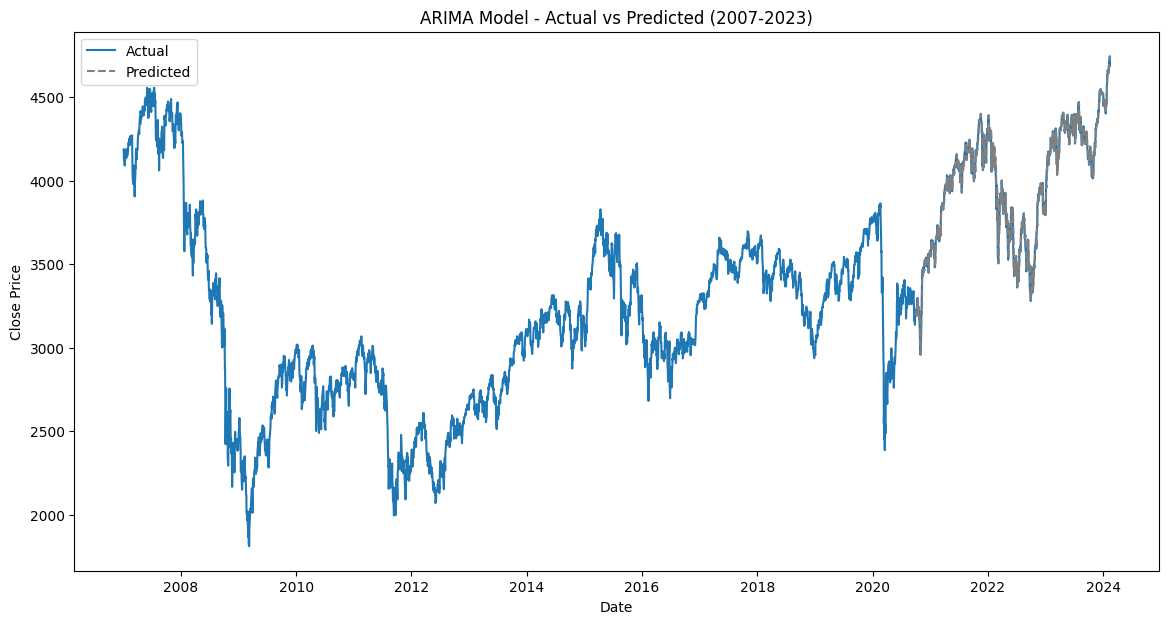

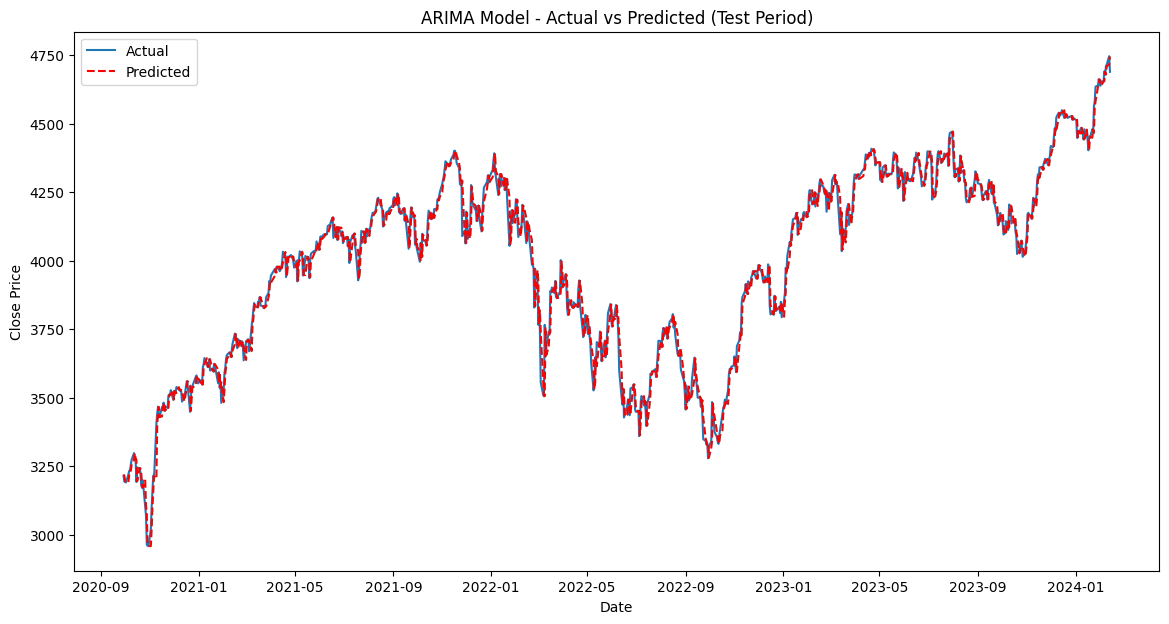

In [54]:
# Plot the actual vs predicted values for the entire period (2007-2023)
plt.figure(figsize=(14, 7))
plt.plot(series, label='Actual')  # Plot full actual series
plt.plot(predicted_series, label='Predicted', color='gray', linestyle='dashed')  # Dashed line for predicted values
plt.title('ARIMA Model - Actual vs Predicted (2007-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Zoom in on the test period to make the predictions more visible
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predicted_series, label='Predicted', color='red', linestyle='dashed')
plt.title('ARIMA Model - Actual vs Predicted (Test Period)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### 3.3 AutoARIMA with Exogenous Variables

In [59]:
def run_model():
    # Extract the 'Close' series and the exogenous variables
    series = dataset_knn_pandas['Close']
    exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate', 
                                    'M3', 'M6', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']]

    # Define the train/test split
    split_point = int(len(series) * 0.8)
    train, test = series.iloc[:split_point], series.iloc[split_point:]
    train_exog, test_exog = exog_vars.iloc[:split_point], exog_vars.iloc[split_point:]

    # Ensure there are no NaN values in the training and test sets, including exogenous variables
    train = train.ffill().bfill()
    test = test.ffill().bfill()
    train_exog = train_exog.ffill().bfill()
    test_exog = test_exog.ffill().bfill()

    # Verify no NaNs exist after filling
    if train.isna().any() or test.isna().any() or train_exog.isna().any().any() or test_exog.isna().any().any():
        raise ValueError("There are still NaNs in the dataset after filling.")

    # Use auto_arima to find the best p, d, q values automatically with exogenous variables
    auto_model = auto_arima(train, X=train_exog, seasonal=False, trace=True, 
                            error_action='ignore', suppress_warnings=True, stepwise=True)

    # Fit the model once on the training data
    auto_model_fit = auto_model.fit(train, X=train_exog)

    # Generate predictions for the test set with a 1-day forecast horizon
    predictions = []
    forecast_horizon = 1

    history = train.copy()
    history_exog = train_exog.copy()

    for start in range(0, len(test), forecast_horizon):
        end = min(start + forecast_horizon, len(test))
        pred = auto_model_fit.predict(n_periods=(end - start), X=test_exog.iloc[start:end])
        predictions.extend(pred)

        # Update the history with the actual test values and exogenous variables using _append()
        history = history._append(test.iloc[start:end])
        history_exog = history_exog._append(test_exog.iloc[start:end])

    # Convert predictions to a Pandas series and align with test data
    predicted_series = pd.Series(predictions, index=test.index[:len(predictions)])

    # Handle NaNs by forward and backward filling
    predicted_series = predicted_series.ffill().bfill()

    # Final NaN check before evaluation
    if predicted_series.isna().any():
        print(predicted_series[predicted_series.isna()])
        raise ValueError("NaNs found in predicted_series after processing.")

    # Ensure the test and predicted series are aligned
    test = test[:len(predicted_series)]
    predicted_series = predicted_series[-len(test):]

    # Evaluate the model
    rmse = sqrt(mean_squared_error(test, predicted_series))
    r2 = r2_score(test, predicted_series)
    mape = np.mean(np.abs((test - predicted_series) / test)) * 100

    # Display the results
    results_df = pd.DataFrame([{'ARIMA_Order': auto_model.order, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}])
    print("\nModel selected by auto_arima:")
    print(results_df)

    # Save the results to a CSV file for later reference
    results_df.to_csv('autoarima_model_with_exogenous_evaluation_results.csv', index=False)

# Profile the function
cProfile.run('run_model()', 'output.pstat')

# Display the profiling results
p = pstats.Stats('output.pstat')
p.sort_stats('cumulative').print_stats(10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=33524.963, Time=35.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35865.823, Time=2.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33652.841, Time=2.90 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=34381.244, Time=16.95 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=33647.449, Time=37.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33662.396, Time=19.48 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=33656.317, Time=36.64 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=33523.705, Time=65.62 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=33650.743, Time=57.52 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=33512.403, Time=60.67 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=33520.492, Time=64.37 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=33509.170, Time=72.24 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=33614.657, Time=61.21 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=33516.524, Time=63.15 sec
 ARIMA(

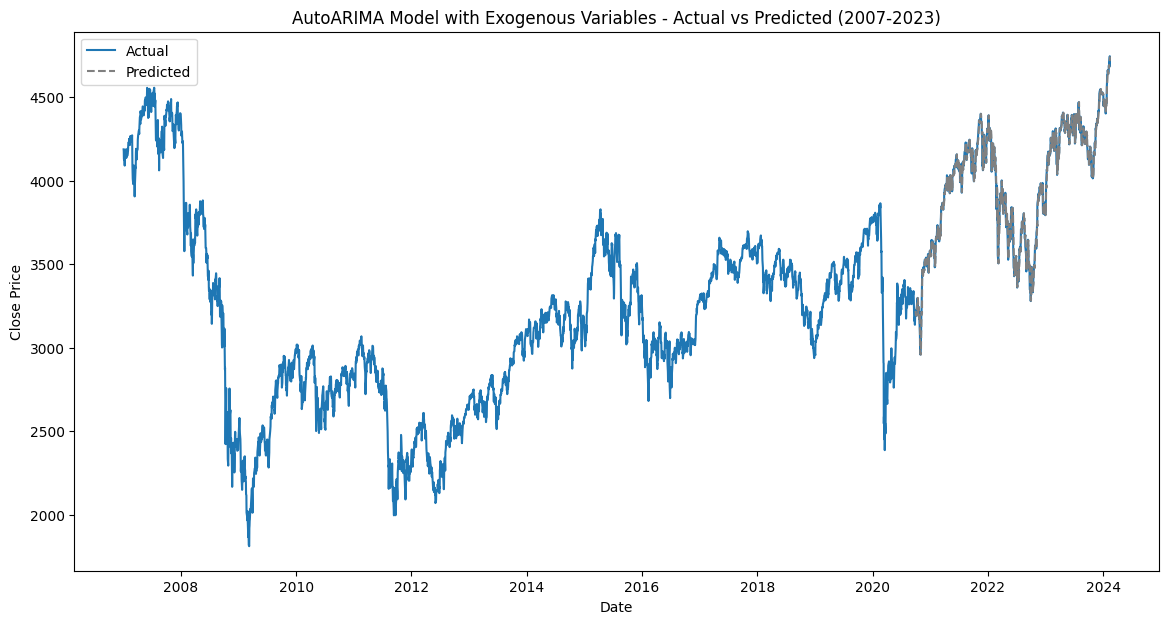

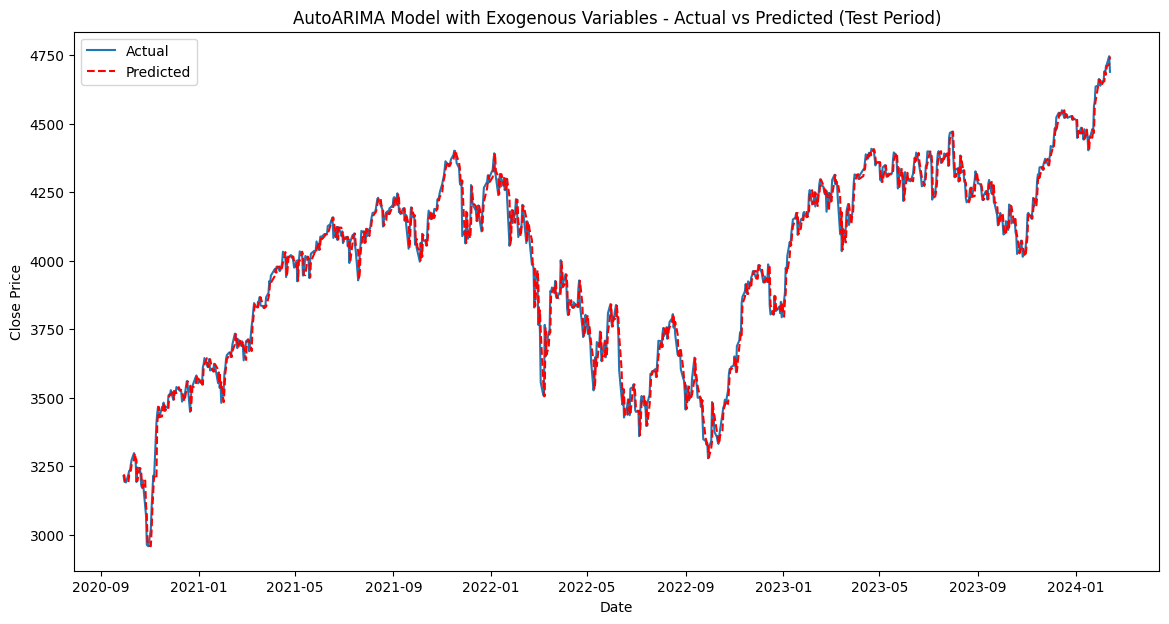

In [60]:
# Plot the actual vs predicted values for the entire period (2007-2023)
plt.figure(figsize=(14, 7))
plt.plot(series, label='Actual')  # Plot full actual series
plt.plot(predicted_series, label='Predicted', color='gray', linestyle='dashed')  # Dashed line for predicted values
plt.title('AutoARIMA Model with Exogenous Variables - Actual vs Predicted (2007-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Zoom in on the test period to make the predictions more visible
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predicted_series, label='Predicted', color='red', linestyle='dashed')
plt.title('AutoARIMA Model with Exogenous Variables - Actual vs Predicted (Test Period)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### 3.4 AutoARIMA with Exogenous Variables - Cross-Validation

In [61]:
def run_and_save_model():
    # Extract the 'Close' series and the exogenous variables
    series = dataset_knn_pandas['Close']
    exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate', 
                                    'M3', 'M6', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']]

    # Define the train/test split
    split_point = int(len(series) * 0.8)
    train = series.iloc[:split_point]
    train_exog = exog_vars.iloc[:split_point]

    # Check if there are no NaN valueses
    train = train.ffill().bfill()
    train_exog = train_exog.ffill().bfill()

    # Verify no NaNs exist after filling
    if train.isna().any() or train_exog.isna().any().any():
        raise ValueError("There are still NaNs in the training dataset after filling.")

    # Fit the model on the full training data
    auto_model = auto_arima(train, X=train_exog, seasonal=False, trace=True, 
                            error_action='ignore', suppress_warnings=True, stepwise=True)
    auto_model_fit = auto_model.fit(train, X=train_exog)

    # Save the trained ARIMA model
    joblib.dump(auto_model_fit, 'arima_model_with_exogenous.pkl')
    print("Model saved as 'arima_model_with_exogenous.pkl'")

if __name__ == "__main__":
    run_and_save_model()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=33524.963, Time=35.98 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35865.823, Time=2.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33652.841, Time=2.40 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=34381.244, Time=16.84 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=33647.449, Time=39.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33662.396, Time=19.65 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=33656.317, Time=37.59 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=33523.705, Time=65.82 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=33650.743, Time=59.42 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=33512.403, Time=60.52 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=33520.492, Time=63.41 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=33509.170, Time=71.09 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=33614.657, Time=62.14 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=33516.524, Time=65.55 sec
 ARIMA(

Model loaded from 'arima_model_with_exogenous.pkl'

Model selected by auto_arima:
  ARIMA_Order       RMSE        R2      MAPE
0   (3, 0, 4)  47.864264  0.981187  0.926421


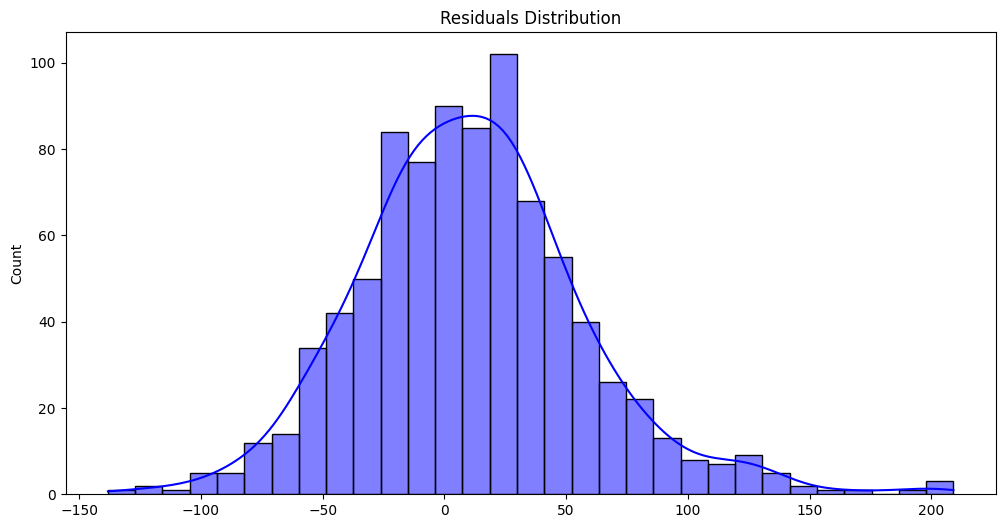

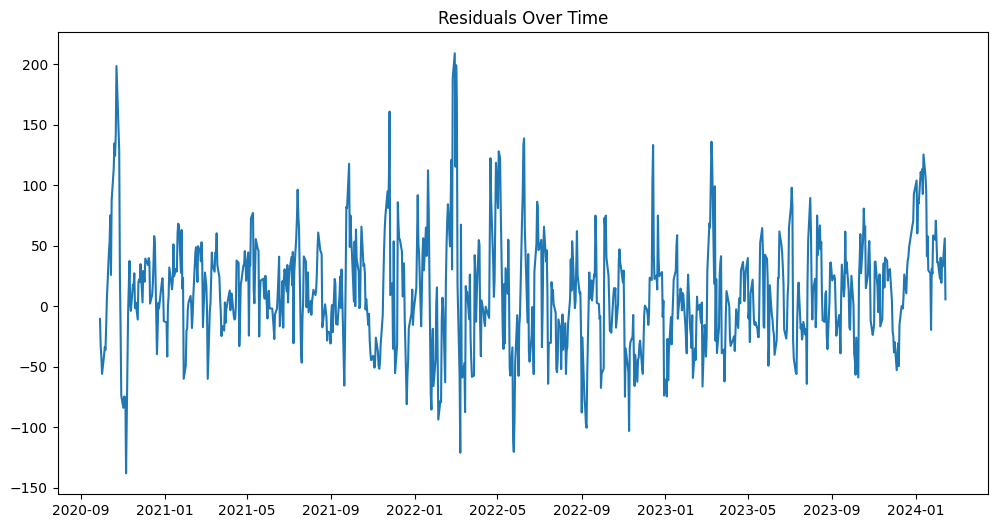

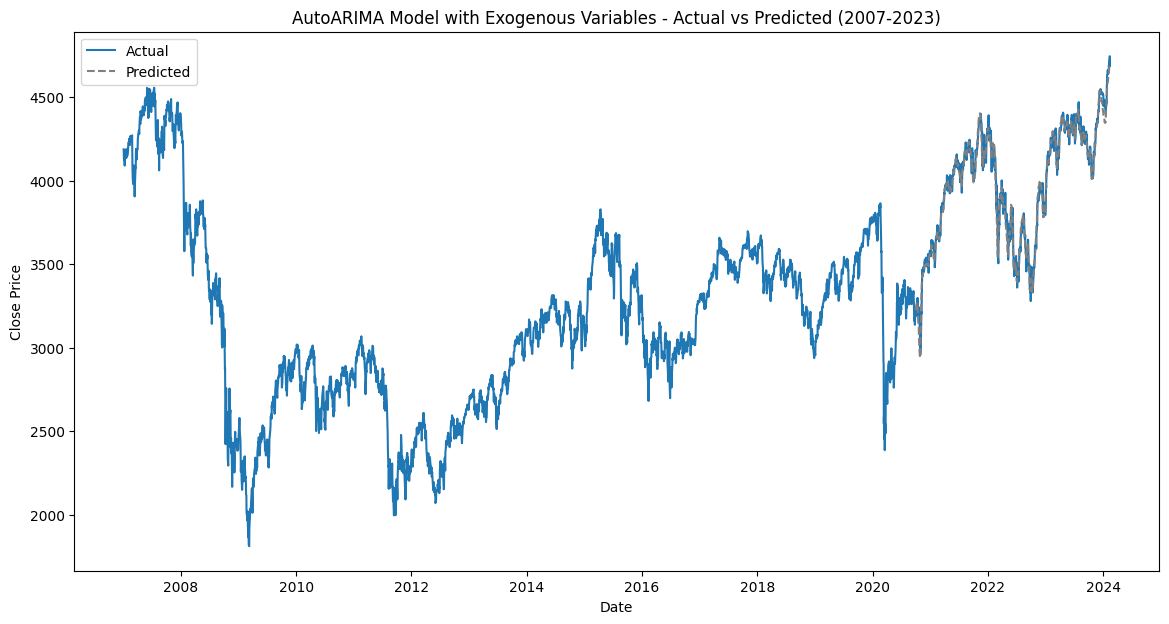

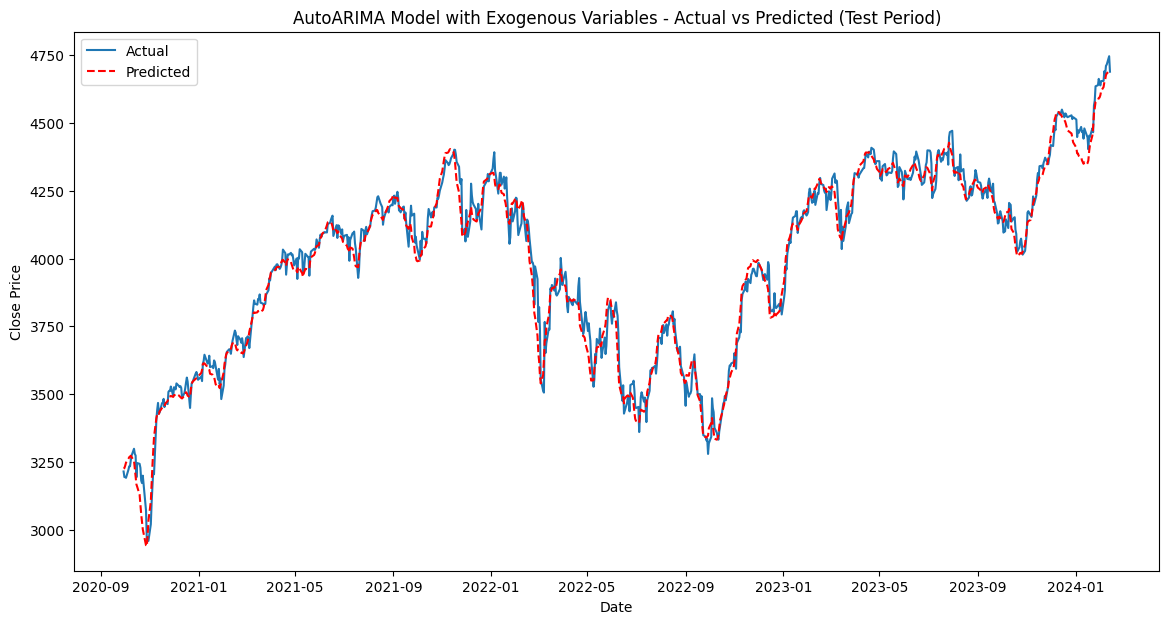

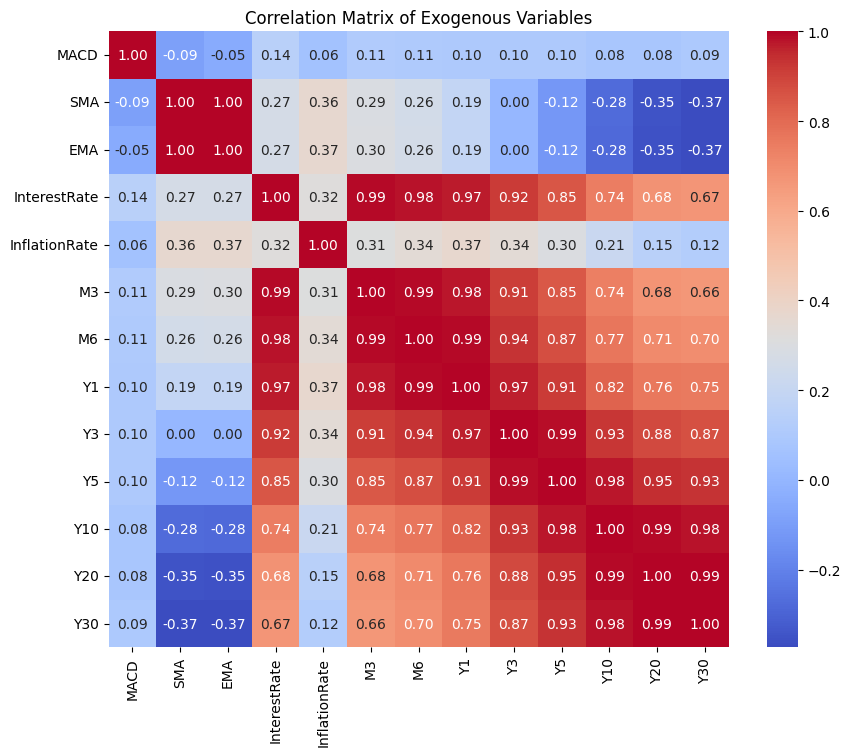

In [62]:
def load_and_show_results():
    # Load the saved ARIMA model
    auto_model_fit = joblib.load('arima_model_with_exogenous.pkl')
    print("Model loaded from 'arima_model_with_exogenous.pkl'")

    # Extract the 'Close' series and the exogenous variables
    series = dataset_knn_pandas['Close']
    exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate', 
                                    'M3', 'M6', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']]

    # Define the train/test split
    split_point = int(len(series) * 0.8)
    test = series.iloc[split_point:]
    test_exog = exog_vars.iloc[split_point:]

    # Ensure there are no NaN values in the test set, including exogenous variables
    test = test.ffill().bfill()
    test_exog = test_exog.ffill().bfill()

    # Generate predictions for the test set with a 1-day forecast horizon
    predictions = []
    forecast_horizon = 1

    for start in range(0, len(test), forecast_horizon):
        end = min(start + forecast_horizon, len(test))
        pred = auto_model_fit.predict(n_periods=(end - start), X=test_exog.iloc[start:end])
        predictions.extend(pred)

    # Convert predictions to a Pandas series and align with test data
    predicted_series = pd.Series(predictions, index=test.index[:len(predictions)])

    # Handle NaNs by forward and backward filling (if still present)
    predicted_series = predicted_series.ffill().bfill()

    # Final NaN check before evaluation
    if predicted_series.isna().any():
        print(predicted_series[predicted_series.isna()])
        raise ValueError("NaNs found in predicted_series after processing.")

    # Ensure the test and predicted series are aligned
    test = test[:len(predicted_series)]
    predicted_series = predicted_series[-len(test):]

    # Evaluate the model
    rmse = sqrt(mean_squared_error(test, predicted_series))
    r2 = r2_score(test, predicted_series)
    mape = np.mean(np.abs((test - predicted_series) / test)) * 100

    # Display the results
    results_df = pd.DataFrame([{'ARIMA_Order': auto_model_fit.order, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}])
    print("\nModel selected by auto_arima:")
    print(results_df)
    
    # Residual Analysis
    residuals = test - predicted_series
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, color='blue')
    plt.title('Residuals Distribution')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(residuals)
    plt.title('Residuals Over Time')
    plt.show()

    # Plot the actual vs predicted values for the entire period (2007-2023)
    plt.figure(figsize=(14, 7))
    plt.plot(series, label='Actual')  # Plot full actual series
    plt.plot(predicted_series, label='Predicted', color='gray', linestyle='dashed')  # Dashed line for predicted values
    plt.title('AutoARIMA Model with Exogenous Variables - Actual vs Predicted (2007-2023)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Zoom in on the test period to make the predictions more visible
    plt.figure(figsize=(14, 7))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, predicted_series, label='Predicted', color='red', linestyle='dashed')
    plt.title('AutoARIMA Model with Exogenous Variables - Actual vs Predicted (Test Period)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Feature Importance Analysis
    # Plot the correlation matrix of exogenous variables
    plt.figure(figsize=(10, 8))
    sns.heatmap(exog_vars.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Exogenous Variables')
    plt.show()

if __name__ == "__main__":
    load_and_show_results()

## 4- ARIMA with Exogenous Variables RNN (LSTM)

### Data Preparation

In [63]:
def prepare_data(dataset_knn_pandas):
    series = dataset_knn_pandas['Close'].values.reshape(-1, 1)
    exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate', 'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']].values
    
    scaler_series = MinMaxScaler(feature_range=(0, 1))
    scaler_exog = MinMaxScaler(feature_range=(0, 1))
    
    series_scaled = scaler_series.fit_transform(series)
    exog_vars_scaled = scaler_exog.fit_transform(exog_vars)
    
    X, y = [], []
    window_size = 5
    for i in range(window_size, len(series_scaled)):
        X.append(np.hstack((series_scaled[i-window_size:i], exog_vars_scaled[i-window_size:i])))
        y.append(series_scaled[i])
    
    X, y = np.array(X), np.array(y)
    
    split_point = int(len(X) * 0.8)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    
    return X_train, X_test, y_train, y_test, scaler_series

# Run the data preparation
X_train, X_test, y_train, y_test, scaler_series = prepare_data(dataset_knn_pandas)

### LSTM Model Architecture

In [64]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the LSTM model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))

### Training the Model

In [65]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

### Evaluate the Model

27/27 [==============================] - 1s 2ms/step
RMSE: 62.76942187715111
R2 Score: 0.967499377076054
MAPE: 1.2514539813284895


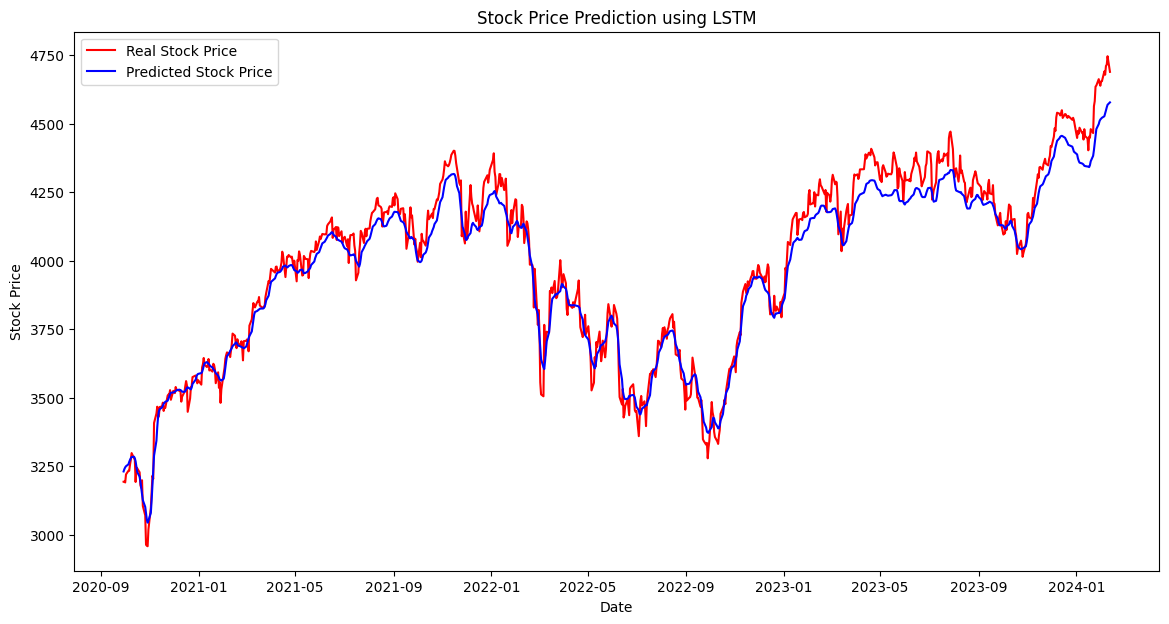

In [66]:
# Predict on the test set
predicted_stock_price = lstm_model.predict(X_test)
predicted_stock_price = scaler_series.inverse_transform(predicted_stock_price)
real_stock_price = scaler_series.inverse_transform(y_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
r2 = r2_score(real_stock_price, predicted_stock_price)
mape = np.mean(np.abs((real_stock_price - predicted_stock_price) / real_stock_price)) * 100

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")
print(f"MAPE: {mape}")

# Convert the test index back to dates
test_dates = test.index

# Adjust lengths to match
min_length = min(len(test_dates), len(real_stock_price))

# Truncate both arrays to the minimum length
test_dates = test_dates[:min_length]
real_stock_price = real_stock_price[:min_length]
predicted_stock_price = predicted_stock_price[:min_length]

# Plot the results with Date Index
plt.figure(figsize=(14,7))
plt.plot(test_dates, real_stock_price, color='red', label='Real Stock Price')
plt.plot(test_dates, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Model saved as lstm_model.h5
45/45 [==============================] - 0s 2ms/step
Train RMSE: 36.1665867873895
Test RMSE: 50.61745508545691
Test MAPE: 1.0608421591312491
Test R²: 0.9872337866445564


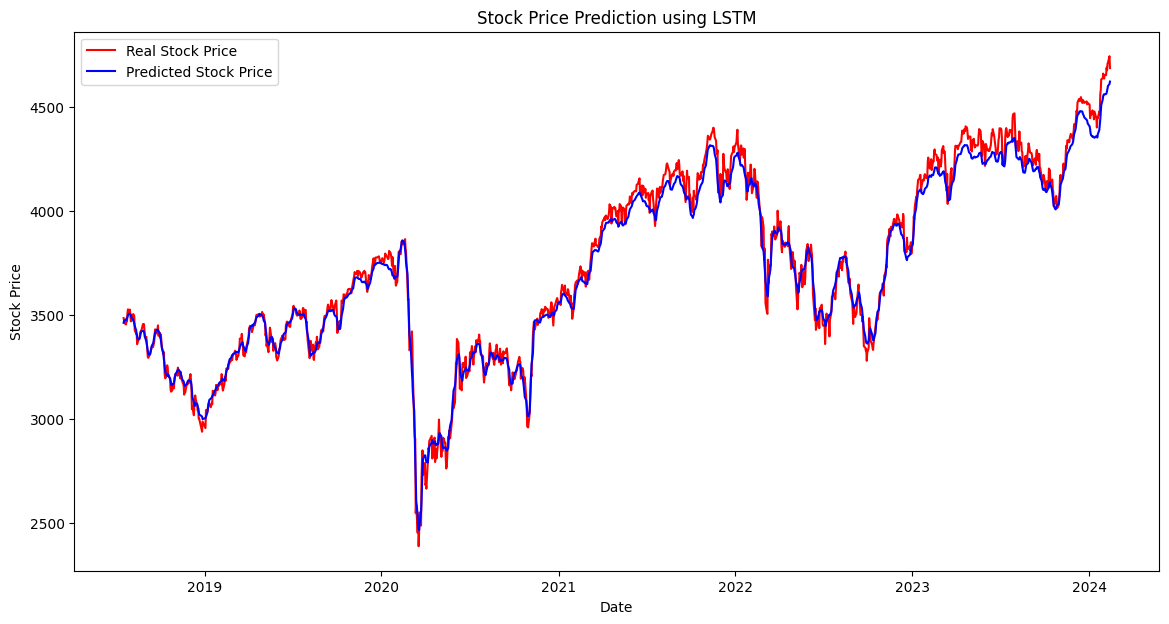

In [67]:
# Define the columns
feature_columns = ['Close', 'InterestRate', 'InflationRate', 'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']
target_column = 'Close'

# Normalizing the data
scaler_series = MinMaxScaler(feature_range=(0, 1))
scaler_exog = MinMaxScaler(feature_range=(0, 1))

series = dataset_knn_pandas['Close'].values.reshape(-1, 1)
exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate', 'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']].values

series_scaled = scaler_series.fit_transform(series)
exog_vars_scaled = scaler_exog.fit_transform(exog_vars)

# Create dataset with lagged features
def create_dataset(series_scaled, exog_vars_scaled, look_back=30):
    X, y = [], []
    for i in range(look_back, len(series_scaled)):
        X.append(np.hstack((series_scaled[i-look_back:i], exog_vars_scaled[i-look_back:i])))
        y.append(series_scaled[i])
    return np.array(X), np.array(y)

# Prepare the dataset
look_back = 30  # 30 Days look_back
X, y = create_dataset(series_scaled, exog_vars_scaled, look_back)

# Split the data into training and testing sets
split_point = int(len(X) * 0.67)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Build and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

# Save the model
model.save('lstm_model.h5')
print("Model saved as lstm_model.h5")

# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions to get them back to the original scale
trainPredict = scaler_series.inverse_transform(np.column_stack((trainPredict, np.zeros((trainPredict.shape[0], X.shape[2]-1)))))
testPredict = scaler_series.inverse_transform(np.column_stack((testPredict, np.zeros((testPredict.shape[0], X.shape[2]-1)))))
y_train_original = scaler_series.inverse_transform(np.column_stack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], X.shape[2]-1)))))
y_test_original = scaler_series.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2]-1)))))

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train_original[:, 0], trainPredict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test_original[:, 0], testPredict[:, 0]))
test_mape = np.mean(np.abs((y_test_original[:, 0] - testPredict[:, 0]) / y_test_original[:, 0])) * 100
test_r2 = r2_score(y_test_original[:, 0], testPredict[:, 0])

# Print the performance metrics
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)
print('Test R²:', test_r2)


test_dates = dataset_knn_pandas.index[split_point + look_back:]
# Adjust lengths to match
min_length = min(len(test_dates), len(y_test_original))

# Truncate both arrays to the minimum length
test_dates = test_dates[:min_length]
y_test_original = y_test_original[:min_length]
testPredict = testPredict[:min_length]

# Plotting the results with Date Index
plt.figure(figsize=(14,7))
plt.plot(test_dates, y_test_original[:, 0], color='red', label='Real Stock Price')
plt.plot(test_dates, testPredict[:, 0], color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Hyperparameter Tuning with Optuna

#### Model Evaluation

In [ ]:
# Load the best model
best_model_path = 'best_model.h5'
best_model = load_model(best_model_path)

# Make predictions on the test set using the best model
predicted_stock_price = best_model.predict(X_test).flatten()

# Reshape the predictions for inverse transformation
dummy_features = np.zeros((predicted_stock_price.shape[0], 1))
dummy_features[:, 0] = predicted_stock_price

# Inverse transform the dummy array to get the predictions back to their original scale
predicted_stock_price = scaler_series.inverse_transform(dummy_features).flatten()

# Convert the real stock price (y_test) back to its original scale
real_stock_price_series = scaler_series.inverse_transform(y_test.reshape(-1, 1)).flatten()


test = dataset_knn_pandas.iloc[train_size + look_back + 1:] 
# Adjust lengths to match
min_length = min(len(test.index), len(real_stock_price_series))

# Truncate both arrays to the minimum length
test_index_aligned = test.index[:min_length]
real_stock_price_series = real_stock_price_series[:min_length]
predicted_stock_price = predicted_stock_price[:min_length]

# Calculate the evaluation metrics
rmse = sqrt(mean_squared_error(real_stock_price_series, predicted_stock_price))
mape = np.mean(np.abs((real_stock_price_series - predicted_stock_price) / real_stock_price_series)) * 100
r2 = r2_score(real_stock_price_series, predicted_stock_price)

# Prepare the results DataFrame
results_df = pd.DataFrame({
    'RMSE': [rmse],
    'MAPE': [mape],
    'R2': [r2]
})

# Save the results to a CSV file
results_filename = 'model_performance_metrics.csv'
results_df.to_csv(results_filename, index=False)
print(f"Results saved to {results_filename}")

# Print the results
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R^2 Score: {r2}")

# Plotting the results with Date Index
plt.figure(figsize=(14,7))
plt.plot(test_index_aligned, real_stock_price_series, color='red', label='Real Stock Price')
plt.plot(test_index_aligned, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction using Best Optimized LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#### Overfitting/Underfitting Analysis

#### Hyperbolic Tangent (Tanh & Sigmoid)

### Retrain the LSTM Model with Hyperparameters

In [73]:
# Selecting the relevant columns for input features and the target variable 'Close'
feature_columns = ['Close', 'InterestRate', 'InflationRate', 'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']
target_column = 'Close'

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset_knn_pandas[feature_columns])

# Function to create a dataset with lagged features
def create_dataset(data, look_back=1):
    X, Y = [], []
    target_idx = dataset_knn_pandas.columns.get_loc(target_column)
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), :]
        X.append(a)
        Y.append(data[i + look_back, target_idx])
    return np.array(X), np.array(Y)

# Prepare the dataset with a specified look back period
look_back = 30
X, Y = create_dataset(scaled_data, look_back)

# Split the data into training and testing sets
train_size = int(len(X) * 0.67)
trainX, trainY = X[:train_size], Y[:train_size]
testX, testY = X[train_size:], Y[train_size:]

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, len(feature_columns)))
testX = np.reshape(testX, (testX.shape[0], look_back, len(feature_columns)))

# Build and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, len(feature_columns))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=0)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(np.column_stack((trainPredict, np.zeros((trainPredict.shape[0], len(feature_columns)-1)))))
testPredict = scaler.inverse_transform(np.column_stack((testPredict, np.zeros((testPredict.shape[0], len(feature_columns)-1)))))
trainY_original = scaler.inverse_transform(np.column_stack((trainY.reshape(-1, 1), np.zeros((trainY.shape[0], len(feature_columns)-1)))))
testY_original = scaler.inverse_transform(np.column_stack((testY.reshape(-1, 1), np.zeros((testY.shape[0], len(feature_columns)-1)))))

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(trainY_original[:, 0], trainPredict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(testY_original[:, 0], testPredict[:, 0]))
test_mape = np.mean(np.abs((testY_original[:, 0] - testPredict[:, 0]) / testY_original[:, 0])) * 100
test_r2 = r2_score(testY_original[:, 0], testPredict[:, 0])

# Print the performance metrics
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)
print('Test R²:', test_r2)

45/45 [==============================] - 0s 3ms/step
Train RMSE: 55.99386081316613
Test RMSE: 63.81122685567781
Test MAPE: 1.263770890143706
Test R²: 0.9796601190591676


45/45 [==============================] - 1s 8ms/step
Results saved to model2_performance_metrics.csv
RMSE: 56.17316581788548
MAPE: 0.011979893804856376%
R^2 Score: 0.9842379747638285


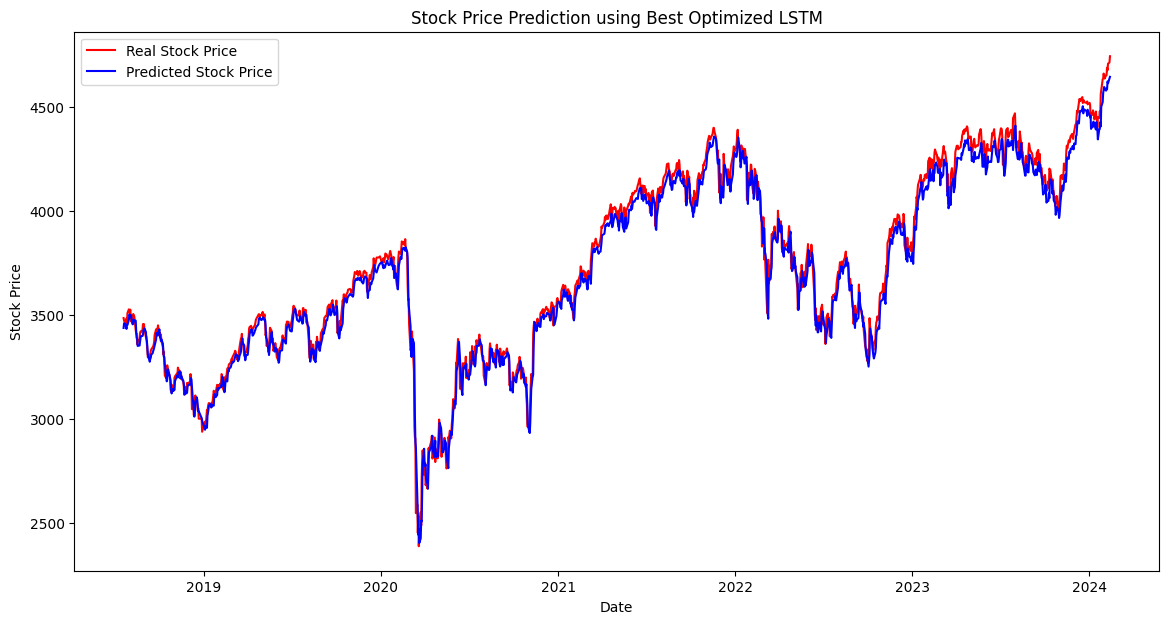

In [74]:
# Load the best model
best_model_path = 'best2_model.h5'
best_model = load_model(best_model_path)

# Evaluate the model
predicted_stock_price = best_model.predict(testX).flatten()

# Create a dummy array for inverse transformation
dummy_features = np.zeros((predicted_stock_price.shape[0], len(feature_columns)))
dummy_features[:, 0] = predicted_stock_price  # Replace only the 'Close' column (assumed to be the first column)

# Inverse transform the dummy array to get the predictions back to their original scale
predicted_stock_price = scaler.inverse_transform(dummy_features)[:, 0]  # Extract the 'Close' column after inverse transform

# Convert the real stock price (testY) back to its original scale
real_stock_price_series = scaler.inverse_transform(np.column_stack((testY.reshape(-1, 1), np.zeros((len(testY), len(feature_columns) - 1)))))[:, 0]


test = dataset_knn_pandas.iloc[train_size + look_back + 1:] 
# Adjust lengths to match
min_length = min(len(test.index), len(real_stock_price_series))

# Truncate both arrays to the minimum length
test_index_aligned = test.index[:min_length]
real_stock_price_series = real_stock_price_series[:min_length]
predicted_stock_price = predicted_stock_price[:min_length]

# Calculate the evaluation metrics
rmse = sqrt(mean_squared_error(real_stock_price_series, predicted_stock_price))
mape = mean_absolute_percentage_error(real_stock_price_series, predicted_stock_price)
r2 = r2_score(real_stock_price_series, predicted_stock_price)

# Prepare the results DataFrame
results_df = pd.DataFrame({
    'RMSE': [rmse],
    'MAPE': [mape],
    'R2': [r2]
})

# Save the results to a CSV file
results_filename = 'model2_performance_metrics.csv'
results_df.to_csv(results_filename, index=False)
print(f"Results saved to {results_filename}")

# Print the results
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R^2 Score: {r2}")

# Plotting the results with Date Index
plt.figure(figsize=(14,7))
plt.plot(test_index_aligned, real_stock_price_series, color='red', label='Real Stock Price')
plt.plot(test_index_aligned, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction using Best Optimized LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 5- ARIMA & LSTM Analyze

## 5.1 Load and Evaluate the ARIMA Model

In [75]:
def load_arima_results():
    # Load the saved ARIMA model
    auto_model_fit = joblib.load('arima_model_with_exogenous.pkl')
    print("Model loaded from 'arima_model_with_exogenous.pkl'")

    # Extract the 'Close' series and the exogenous variables
    series = dataset_knn_pandas['Close']
    exog_vars = dataset_knn_pandas[['MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate', 
                                    'M3', 'M6', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']]

    # Define the train/test split
    split_point = int(len(series) * 0.8)
    test = series.iloc[split_point:]
    test_exog = exog_vars.iloc[split_point:]

    # Ensure there are no NaN values in the test set, including exogenous variables
    test = test.ffill().bfill()
    test_exog = test_exog.ffill().bfill()

    # Generate predictions for the test set with a 5-day forecast horizon
    predictions = []
    forecast_horizon = 5

    for start in range(0, len(test), forecast_horizon):
        end = min(start + forecast_horizon, len(test))
        pred = auto_model_fit.predict(n_periods=(end - start), X=test_exog.iloc[start:end])
        predictions.extend(pred)

    # Convert predictions to a Pandas series and align with test data
    predicted_series = pd.Series(predictions, index=test.index[:len(predictions)])

    # Evaluate the model
    rmse = sqrt(mean_squared_error(test, predicted_series))
    r2 = r2_score(test, predicted_series)
    mape = np.mean(np.abs((test - predicted_series) / test)) * 100

    # Save results to be used later for comparison
    arima_metrics = {'RMSE': rmse, 'R2': r2, 'MAPE': mape}
    return test, predicted_series, arima_metrics

arima_test, arima_predicted, arima_metrics = load_arima_results()

Model loaded from 'arima_model_with_exogenous.pkl'


## 5.2 Load and Evaluate the LSTM Model

In [76]:
def load_lstm_results():
    # Load the best LSTM model
    best_model_path = 'best2_model.h5'
    best_model = load_model(best_model_path)

    # Evaluate the model
    predicted_stock_price = best_model.predict(testX).flatten()

    # Create a dummy array for inverse transformation
    dummy_features = np.zeros((predicted_stock_price.shape[0], len(feature_columns)))
    dummy_features[:, 0] = predicted_stock_price  # Replace only the 'Close' column

    # Inverse transform the dummy array to get the predictions back to their original scale
    predicted_stock_price = scaler.inverse_transform(dummy_features)[:, 0]  # Extract the 'Close' column

    # Convert the real stock price (testY) back to its original scale
    real_stock_price_series = scaler.inverse_transform(np.column_stack((testY.reshape(-1, 1), np.zeros((len(testY), len(feature_columns) - 1)))))[:, 0]

    # Adjust lengths to match
    min_length = min(len(test.index), len(real_stock_price_series))
    real_stock_price_series = real_stock_price_series[:min_length]
    predicted_stock_price = predicted_stock_price[:min_length]

    # Calculate the evaluation metrics
    rmse = sqrt(mean_squared_error(real_stock_price_series, predicted_stock_price))
    mape = np.mean(np.abs((real_stock_price_series - predicted_stock_price) / real_stock_price_series)) * 100
    r2 = r2_score(real_stock_price_series, predicted_stock_price)

    # Save results to be used later for comparison
    lstm_metrics = {'RMSE': rmse, 'R2': r2, 'MAPE': mape}
    return real_stock_price_series, predicted_stock_price, lstm_metrics

lstm_real, lstm_predicted, lstm_metrics = load_lstm_results()

45/45 [==============================] - 1s 8ms/step


## 5.3 Comparative Metrics

In [77]:
# Create a DataFrame to compare the results
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'RMSE': [arima_metrics['RMSE'], lstm_metrics['RMSE']],
    'R2': [arima_metrics['R2'], lstm_metrics['R2']],
    'MAPE': [arima_metrics['MAPE'], lstm_metrics['MAPE']]
})

print(comparison_df)
comparison_df.to_csv('arima_vs_lstm_comparison.csv', index=False)

   Model       RMSE        R2      MAPE
0  ARIMA  47.003465  0.981858  0.918011
1   LSTM  56.173166  0.984238  1.197989


## 5.4 Prediction vs Actual Plot for ARIMA and LSTM

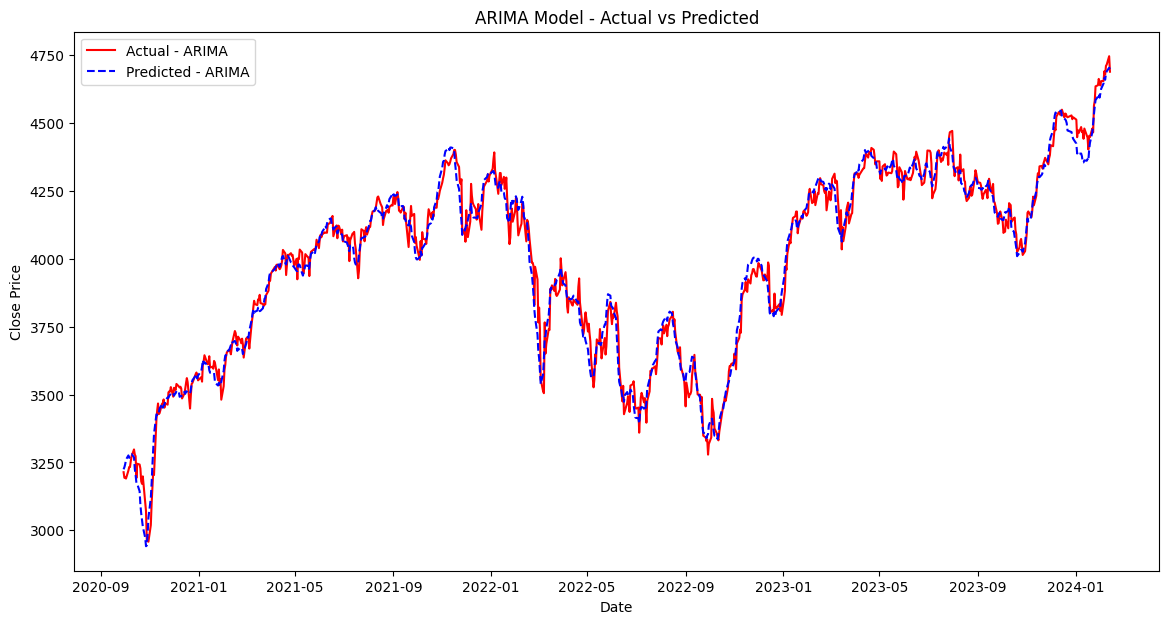

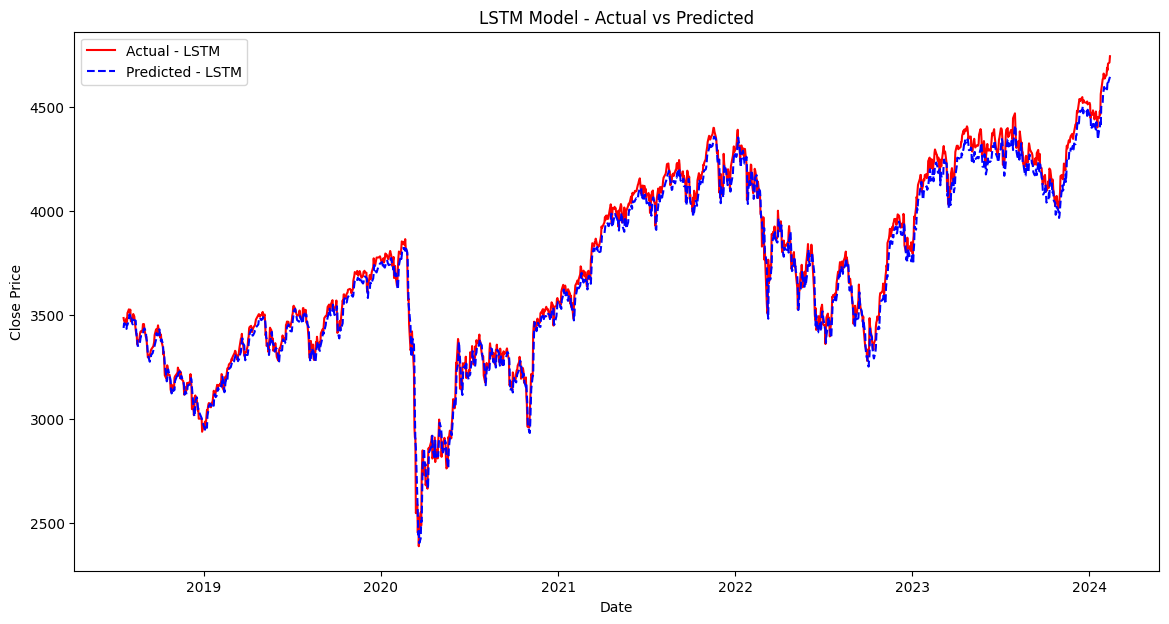

In [78]:
# Plot for ARIMA vs Actual
plt.figure(figsize=(14,7))
plt.plot(arima_test.index, arima_test, color='red', label='Actual - ARIMA')
plt.plot(arima_predicted.index, arima_predicted, color='blue', label='Predicted - ARIMA', linestyle='dashed')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot for LSTM vs Actual
plt.figure(figsize=(14,7))
plt.plot(test_index_aligned, lstm_real, color='red', label='Actual - LSTM')
plt.plot(test_index_aligned, lstm_predicted, color='blue', label='Predicted - LSTM', linestyle='dashed')
plt.title('LSTM Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## 5.5: Plot ARIMA and LSTM Forecasts along with Actual Data

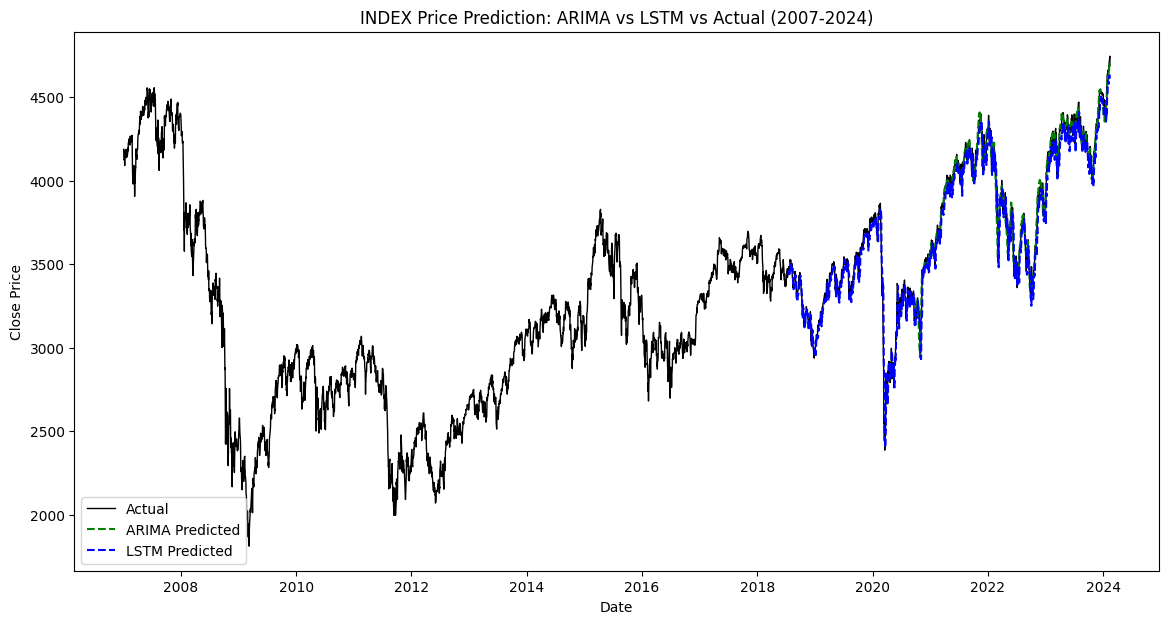

In [81]:
# Plot the full actual series (2007-2024)
plt.figure(figsize=(14, 7))
plt.plot(dataset_knn_pandas['Close'], label='Actual', color='black', linewidth=1)

# Plot the ARIMA predictions
plt.plot(arima_predicted.index, arima_predicted, label='ARIMA Predicted', color='green', linestyle='dashed')

# Plot the LSTM predictions
plt.plot(test_index_aligned, lstm_predicted, label='LSTM Predicted', color='blue', linestyle='dashed')

# Add titles and labels
plt.title('INDEX Price Prediction: ARIMA vs LSTM vs Actual (2007-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Show the plot
plt.show()

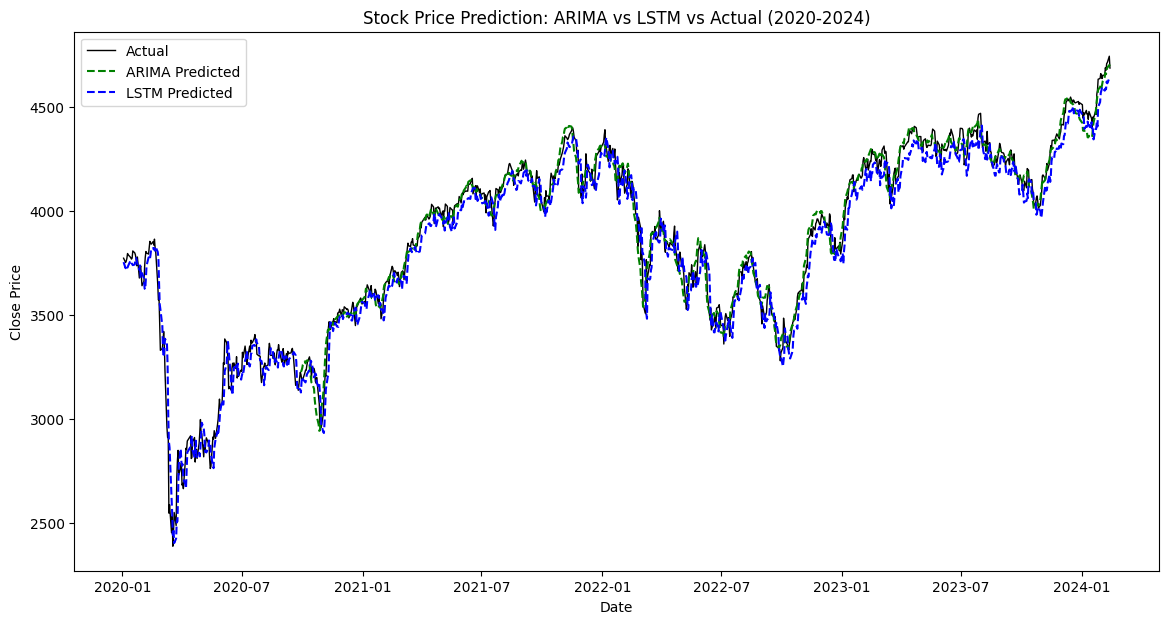

In [82]:
# Define the start and end dates for the plot (2020 to 2024)
start_date = '2020-01-01'
end_date = '2024-12-31'

# Filter the data for the specified date range
actual_filtered = dataset_knn_pandas['Close'].loc[start_date:end_date]
lstm_predicted_filtered = pd.Series(lstm_predicted, index=test_index_aligned).loc[start_date:end_date]
arima_predicted_filtered = arima_predicted.loc[start_date:end_date]

# Plot the filtered actual series (2020-2024)
plt.figure(figsize=(14, 7))
plt.plot(actual_filtered, label='Actual', color='black', linewidth=1)

# Plot the filtered ARIMA predictions
plt.plot(arima_predicted_filtered.index, arima_predicted_filtered, label='ARIMA Predicted', color='green', linestyle='dashed')

# Plot the filtered LSTM predictions
plt.plot(lstm_predicted_filtered.index, lstm_predicted_filtered, label='LSTM Predicted', color='blue', linestyle='dashed')

# Add titles and labels
plt.title('Stock Price Prediction: ARIMA vs LSTM vs Actual (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Show the plot
plt.show()